### Overview <a id=ov>

After the imports and a brief global variable definition (paths and names) we:

1. [Order Files](#src_files)
2. [Construct Dataframes](#src_df) 
3. [Results](#res)<br>
    3.1 [Overview Table](#res_table)<br>
    3.2 [Plots](#res_plots)
4. [Experiment Script](#experiments)

In [1]:
import tarfile
import os
import shutil

import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from itertools import cycle

from tqdm.notebook import tqdm

from collections import namedtuple

In [2]:
n_cs = 4

In [3]:
tar_name = 'experiment_data3'
root_dir = f'./result_data_charging_pt_wepa/cs_{n_cs}'
root_dir_extraction = f'{root_dir}/result_data_remote3'

sns.set_style("whitegrid")
sns.set_context("talk")

In [4]:
%%time

shortnames = {
    'COL': 'COL',
    ' COL': 'COL',
    ' CTD': 'CTD',
    ' CTNR': 'CTNR',
    ' SL': 'SL',
    ' SLO': 'SLO',
    'RND':'RND',
    'allOrdersPopularity_future_z2': 'AOPF2',
    'allOrdersPopularity_future_z3': 'AOPF3',
    'allOrdersPopularity_future_z5': 'AOPF5',
    'allOrdersPopularity_past_z2': 'AOPP2',
    'allOrdersPopularity_past_z3': 'AOPP3',
    'allOrdersPopularity_past_z5': 'AOPP5',
    'classBasedCycleTime_z2': 'CBCT2',
    'classBasedCycleTime_z3': 'CBCT3',
    'classBasedCycleTime_z5': 'CBCT5',
    'retrievalPopularity_future_z2': 'ROPF2',
    'retrievalPopularity_future_z3': 'ROPF3',
    'retrievalPopularity_future_z5': 'ROPF5',
    'retrievalPopularity_past_z2': 'ROPP2',
    'retrievalPopularity_past_z3': 'ROPP3',
    'retrievalPopularity_past_z5': 'ROPP5',
    'VeryGreedy COL': 'GCOL',
    'DQN': 'COL',
    'SAC': 'SAC'
}

CPU times: total: 0 ns
Wall time: 0 ns


### 1. Order Files <a id=src_files>

[Back to Overview](#ov)

In [5]:
%%time

def extract_result_files(src_path, tgt_path):
    if not os.path.exists(src_path):
        print("Tarball not found; skipping...")
        return
    tar = tarfile.open(src_path)
    for member in tar.getmembers():
        if member.isreg():  # skip if the TarInfo is not files
            # remove the path by reset it    
            member.name = os.path.basename(member.name) 
            tar.extract(member, tgt_path) # extract 
    # tar.extractall(root_dir_extraction)
    tar.close()

extract_result_files(f"{root_dir}/{tar_name}", root_dir_extraction)

Tarball not found; skipping...
CPU times: total: 0 ns
Wall time: 1 ms


In [6]:
%%time

def order_files(src_dir):
    files = os.listdir(src_dir)
    pbar = tqdm(total=len(files))
    for i in range(len(files)):
        f_name = files[i]
        print(f_name)
        if not f_name.endswith('.csv') or 'actions' in f_name:
            continue
        segs = f_name.split('_')
        pt = segs[1]
        charging_policy = segs[3]
        th = segs[4]
        name = segs[2]
        new_name = shortnames[name]
        orders = f'{int(segs[-1].split(".")[0]):06}'
        tgt_dir = f'{src_dir}/partition_{pt}/{th}/{new_name}/'
        if not os.path.exists(tgt_dir):
            os.makedirs(tgt_dir)
        shutil.move(f'{src_dir}/{f_name}', 
                    f'{tgt_dir}/{orders}.csv')
        pbar.update(1)
        
order_files(root_dir)

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: './result_data_charging_pt_wepa_4'

In [189]:
root_dir

'./result_data_charging_pt_wepa'

In [154]:
f_name = "pt_0_DQN_RL_thDQN_1001.csv"
segs = f_name.split('_')
if "future" in segs or "past" in segs: 
    name = segs[0] + "_" + segs[1] + "_" + segs[2]
    charging_policy = segs[3]
    th = segs[4]
elif "z2" in segs or "z3" in segs or "z5" in segs:
    name = segs[0] + "_" + segs[1]
    charging_policy = segs[2]
    th = segs[3]
elif "pt" in segs:
    pt = segs[1]
    charging_policy = segs[3]
    th = segs[4]
    name = segs[2]
else:
    charging_policy = segs[1]
    th = segs[2]
    name = segs[0]
orders = f'{int(segs[-1].split(".")[0]):06}'
new_name = shortnames[name]
tgt_dir = f'{root_dir}/partition_{pt}/{th}/{new_name}/'


In [155]:
tgt_dir

'./result_data_charging_pt_wepa/partition_0/thDQN/COL/'

### 2. Construct Dataframes <a id ='src_df'>

[Back to Overview](#ov)

In [6]:
import json
root_dir_partitions = '../1_environment/slapstack/slapstack/use_cases/wepastacks_bm/partitions/'

def load_partitions_data(path):
    col_orders = ["order", "SKU", "arrival", "dock", "batch", "week"]
    col_fill_lvl = ["SKU", "amount"]
    orders = json.load(open(f'{path}_orders.json')) 
    fill_level = json.load(open(f'{path}_fill_lvl.json')) 
    return (pd.DataFrame(columns=col_orders, data=orders), 
            pd.DataFrame.from_dict(data=fill_level, orient='index'))

orders_dict = dict({})
fill_lvls_dict = dict({})
n_partitions = 20

for pt_idx in range(n_partitions):
    orders_dict[pt_idx] = []
    fill_lvls_dict[pt_idx] = []
    orders, fill_level = load_partitions_data(f'{root_dir_partitions}{pt_idx}_partition')
    if orders is not None:
        orders_dict[pt_idx].append(orders)
    if fill_level is not None:
        fill_lvls_dict[pt_idx].append(fill_level)
        
total_locations = 19512
fill_lvls = []
for pt_idx in range(n_partitions):
    fill_lvls.append(float((fill_lvls_dict[pt_idx][0].sum() / total_locations) * 100))
    
def agg_overall_stocklevels(row):
    global current_stock_overall
    
    #update current_stock_overall
    current_level = row['amount_change'] + current_stock_overall
    current_stock_overall = current_level
    return current_level

def convert_time(row):
    return pd.Timestamp(row["arrival"], unit='s') 

total_locations = 19512

for idx in orders_dict.keys():
    current_partition = orders_dict[idx][0]
    current_partition.loc[current_partition['order'] == 'retrieval', 'amount_change'] = -1
    current_partition.loc[current_partition['order'] == 'delivery', 'amount_change'] = 1

    current_stock_overall = fill_lvls_dict[idx][0].sum()
    
    current_partition['current_stock_overall'] = current_partition.apply(agg_overall_stocklevels, axis = 1)
    current_partition["fill_level"] = current_partition["current_stock_overall"] / total_locations
    
    current_partition["arrival_datetime"] = current_partition.apply(lambda x: convert_time(x), axis=1)
    current_partition["date"] = current_partition["arrival_datetime"].apply(lambda x: x.strftime("%Y-%m-%d"))
    current_partition["day"] = current_partition["arrival_datetime"].apply(lambda x: x.weekday())
    current_partition["hour"] = current_partition["arrival_datetime"].apply(lambda x: x.hour)
    current_partition["partition"] = idx
    try:
        assert  fill_lvls_dict[idx+1][0].sum()[0] == current_partition.iloc[-1]["current_stock_overall"]
    except KeyError:
        print("Key")

C:\Users\zm0714\AppData\Local\Temp\ipykernel_27500\2486894112.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  fill_lvls.append(float((fill_lvls_dict[pt_idx][0].sum() / total_locations) * 100))


Key


In [7]:
%%time

def load_storage_strategy_dataframe(data_root):
    n_zones = 3
    try:
        strategy_name = data_root.split('/')[3]
        # n_zones = int(strategy_name[-1]) if strategy_name[-1].isdigit() else 3
    except:
        strategy_name = "DQN"
    if not os.path.exists(data_root):
        print(f"did not find path {data_root}; skipping...")
        return
    dfs = []
    csv_f_names = os.listdir(data_root)
    # pbar = tqdm(total=len(csv_f_names))
    print(f'Loading result files into dataframes for the '
          f'{strategy_name} simulation run...')
    for f_name in csv_f_names:
        if os.path.isdir(f'{data_root}/{f_name}') or f_name == '.DS_Store':
            #print(f'{data_root}/{f_name}')
            continue
        df_result_part = pd.read_csv(f'{data_root}/{f_name}', index_col=0)
        n_rows = df_result_part.shape[0]
        df_result_part['strategy_name'] = [strategy_name] * n_rows
        df_result_part['n_zones'] = [n_zones] * n_rows
        dfs.append(df_result_part)
        # print(strategy_name, n_zones, order_set_nr)
        # pbar.update(1)
    strategy_df = pd.concat(dfs).reset_index(drop=True)
    strategy_df.name = strategy_name
    return strategy_df

# dfs_d = dict({})
# n_agvs = 40
# for n_cs in range(1,9):
#     dfs_d[n_cs] = []
#     for shortname in shortnames.values():
#         df = load_storage_strategy_dataframe(
#             f'{root_dir}/n_agvs__{n_agvs}/n_cs__{n_cs}/{shortname}')
#         if df is not None:
#             dfs_d[n_cs].append(df)
dfs_d = dict({})
partitions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
# thresholds = [40, 50, 60, 70, 80, "dqn_best_model", "random", "no_battery_constraints", "sac"]
#thresholds = [40, 50, 60, 70, 80, 90, 100, "random", "no_battery_constraints", "sac", "dqn"]
thresholds = [30, 40, 50, 60, 70, 80, 90, 100, "random", "DQN", "SAC"] #"lower_bound", "SAC", "DQN"
for pt in partitions:
    print(f"Loading partition {pt}")
    dfs_d[pt] = []
    for th in thresholds:
        if not th == "SAC":
            path = f'{root_dir}/partition_{pt}/th{th}/COL'
        else: 
            path = f'{root_dir}/partition_{pt}/th{th}/SAC'
        df = load_storage_strategy_dataframe(path)
        if df is not None:
            dfs_d[pt].append(df)


Loading partition 0
Loading result files into dataframes for the partition_0 simulation run...
Loading result files into dataframes for the partition_0 simulation run...
Loading result files into dataframes for the partition_0 simulation run...
Loading result files into dataframes for the partition_0 simulation run...
Loading result files into dataframes for the partition_0 simulation run...
Loading result files into dataframes for the partition_0 simulation run...
Loading result files into dataframes for the partition_0 simulation run...
Loading result files into dataframes for the partition_0 simulation run...
Loading result files into dataframes for the partition_0 simulation run...
Loading result files into dataframes for the partition_0 simulation run...
Loading result files into dataframes for the partition_0 simulation run...
Loading partition 1
Loading result files into dataframes for the partition_1 simulation run...
Loading result files into dataframes for the partition_1 sim

In [8]:
root_dir

'./result_data_charging_pt_wepa/cs_4'

In [9]:
dfs_d_actions = dict({})
models = ["SAC", "DQN"]
for pt in partitions:
    dfs_d_actions[pt] = []
    for model in models:
        path = f'./{root_dir}/pt_{pt}_th{model}_actions.csv'
        # path = f'{root_dir}/'
        # df = load_storage_strategy_dataframe(path)
        df = pd.read_csv(path)
        df.name = pt
        df["strategy_name"] = model
        if df is not None:
            dfs_d_actions[pt].append(df)

In [10]:
thresholds = [40, 50, 60, 70, 80]
for pt in dfs_d_actions.keys():
    dfs_d_actions[pt][1]["Action"] = dfs_d_actions[pt][1]["Action"].apply(lambda x: thresholds[x])

In [19]:
dfs_d_actions[0][1]


,Unnamed: 0,Step,Action,kpi__makespan,strategy_name
0,0,1,70,194026.1000,DQN
1,0,2,50,199565.3000,DQN
2,0,3,80,202576.7000,DQN
3,0,4,80,203886.7000,DQN
4,0,5,70,204247.5000,DQN
...,...,...,...,...,...
208,0,209,80,469982.9000,DQN
209,0,210,80,470131.6000,DQN
210,0,211,80,471230.4000,DQN
211,0,212,80,471257.2000,DQN


# Tensorboard

In [20]:
def get_tensorboard_logs(path, dfs_d):
    dfs = []
    run = "0"
    csv_f_names = os.listdir(path)
    print(csv_f_names)
    # pbar = tqdm(total=len(csv_f_names))
    # print(f'Loading result files into dataframes for the '
    #       f'{strategy_name} simulation run...')
    for f_name in csv_f_names:
        print(f_name)
        if os.path.isdir(f'{path}/{f_name}') or f_name == ".DS_Store":
            continue
        run = f_name.split('_')[-1]
        net = f_name.split('_')[5]
        buffer = f_name.split('_')[2]
        
        df_result_part = pd.read_csv(f'{path}/{f_name}', sep=',')
        n_rows = df_result_part.shape[0]
        df_result_part['strategy_name'] = model + '_' + run
        
        df_result_part = df_result_part.assign(episode=df_result_part.reset_index().index)
        df_result_part.name = model + '_' + net + '_' + net + '_' + buffer
        dfs.append(df_result_part)
        # print(strategy_name, n_zones, order_set_nr)
        # pbar.update(1)
        #dfs_d_tensorboard[model].append(df_result_part)
    # strategy_df = pd.concat(dfs).reset_index(drop=True)
    # strategy_df.name = model
    for df in dfs:
        dfs_d[model].append(df)
    return dfs_d

In [21]:
data_root = './tensorboard_logs'
dfs_d_tensorboard_rewards = dict({})
dfs_d_tensorboard_episode = dict({})
dfs_d_tensorboard_loss = dict({})
dfs_d_tensorboard_entropy = dict({})
models = ["DQN", "SAC"]

for model in models:
    dfs_d_tensorboard_rewards[model] = []
    dfs_d_tensorboard_episode[model] = []
    dfs_d_tensorboard_loss[model] = []
    dfs_d_tensorboard_entropy[model] = []
    path = f'{data_root}/{model}/rewards'
    dfs_d_tensorboard_rewards = get_tensorboard_logs(path, dfs_d_tensorboard_rewards)
    path = f'{data_root}/{model}/episode_length'
    dfs_d_tensorboard_episode = get_tensorboard_logs(path, dfs_d_tensorboard_episode)
    path = f'{data_root}/{model}/loss'
    dfs_d_tensorboard_loss = get_tensorboard_logs(path, dfs_d_tensorboard_loss)
    if model == "DQN":
        continue
    else:
        path = f'{data_root}/{model}/ent_coef'
        dfs_d_tensorboard_entropy = get_tensorboard_logs(path, dfs_d_tensorboard_entropy)

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: './tensorboard_logs/DQN/rewards'

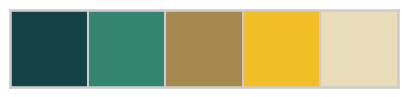

In [22]:
hex_colors = ['#144246', 
              #'#69657e', 
              '#338470', 
              '#a6874e', 
              #'#FFFF33', '#FFD801', '#FFDF00', 
              '#f2be25', '#e8dcb9']
pal = sns.color_palette(hex_colors, desat=1)
sns.palplot(pal)

In [18]:
from copy import deepcopy
def plot_cs_constraints(df, indicator, limit, y_label):
    _, ax = plt.subplots(figsize=(8, 4.5))
    #ax.ticklabel_format(axis='x', style='sci')
    
    # palette = cycle(pal)
    xlim = 0
    
    ax = sns.lineplot(
        ax=ax, x=df.index, y=df[indicator], 
        label="Baseline")
    
                # df_parametrization_check['n_cs'] = [n_cs] 
    ax.axhline(limit, 
               color='red', linestyle='dashdot', label='Limit') 
    
    # ax.legend(title='AMR Number')
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Partition')
    ax.set_ylabel(y_label)
    
    # plt.savefig(f'{root_dir}/constraints__{indicator}.png', 
    #             dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()


# RL training viz

In [ ]:
dfs_d_tensorboard_loss["DQN"]

In [ ]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)

ax = sns.lineplot(ax=ax, x='Step', y='Value', color=next(palette), data=dfs_d_tensorboard_loss["DQN"][0])

# ax.legend(title='DQN Results')  
#ax.set_xlim((-5000, xlim + 20000))
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
plt.savefig(f'{root_dir}/plot__rl__loss_r0.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
for df in dfs_d_tensorboard_rewards["DQN"][1:]:
    ax = sns.lineplot(ax=ax, x='Step', y='Value', 
                        label=df.name, color=next(palette), data=df)
    
    # ax.legend(title='DQN Results')  
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Step')
    ax.set_ylabel('Mean Episode Length')
plt.savefig(f'{root_dir}/plot__rl__reward_r1_dqn.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
for i, df in enumerate(dfs_d_tensorboard_rewards["DQN"][1:]):
    segments = df.name.split("_")
    print(segments)
    model = segments[0]
    net = segments[1]
    name = model + "_" + net + "_" + str(i) 
    ax = sns.lineplot(ax=ax, x='Step', y='Value', 
                        label=df.name, color=next(palette), data=df)
    
    # ax.legend(title='DQN Results')  
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Step')
    ax.set_ylabel('Mean Reward')
plt.savefig(f'{root_dir}/plot__rl__reward_r1_dqn.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
for i, df in enumerate(dfs_d_tensorboard_loss["DQN"][1:]):
    segments = df.name.split("_")
    print(segments)
    model = segments[0]
    net = segments[1]
    name = model + "_" + net + "_" + str(i) 
    ax = sns.lineplot(ax=ax, x='Step', y='Value', 
                        label=df.name, color=next(palette), data=df)
    
    # ax.legend(title='DQN Results')  
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
plt.savefig(f'{root_dir}/plot__rl__loss_r1_dqn.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
for i, df in enumerate(dfs_d_tensorboard_loss["DQN"][2:]):
    segments = df.name.split("_")
    print(segments)
    model = segments[0]
    net = segments[1]
    name = model + "_" + net + "_" + str(i) 
    ax = sns.lineplot(ax=ax, x='Step', y='Value', 
                        label=df.name, color=next(palette), data=df[df["Step"]<=20000])
    
    # ax.legend(title='DQN Results')  
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
plt.savefig(f'{root_dir}/plot__rl__loss_r1.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
# for i, df in enumerate(dfs_d_tensorboard_rewards["SAC"]):
    # segments = df.name.split("_")
    # print(segments)
    # model = segments[0]
    # net = segments[1]
    # name = model + "_" + net + "_" + str(i) 
df = dfs_d_tensorboard_rewards["SAC"][1]
ax = sns.lineplot(ax=ax, x='Step', y='Value', 
                    label="SAC_256_256_1000", color=next(palette), data=df)

# ax.legend(title='DQN Results')  
#ax.set_xlim((-5000, xlim + 20000))
ax.set_xlabel('Step')
ax.set_ylabel('Mean Reward')
plt.savefig(f'{root_dir}/plot__rl__reward_r2_sac.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
# for i, df in enumerate(dfs_d_tensorboard_rewards["SAC"]):
    # segments = df.name.split("_")
    # print(segments)
    # model = segments[0]
    # net = segments[1]
    # name = model + "_" + net + "_" + str(i) 
#dfs_d_tensorboard_rewards["SAC"][1]
df = dfs_d_tensorboard_loss["SAC"][1]
ax = sns.lineplot(ax=ax, x='Step', y='Value', 
                    label="SAC_256_256_1000", color=next(palette), data=df)

# ax.legend(title='DQN Results')  
#ax.set_xlim((-5000, xlim + 20000))
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
plt.savefig(f'{root_dir}/plot__rl__loss_r2_sac.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
# segments = df.name.split("_")
# model = segments[0]
# net = segments[1]
# name = model + "_" + net + "_" + str(i) 
ax = sns.lineplot(ax=ax, x='Step', y='Value', 
                    label="R0", color=next(palette), data=dfs_d_tensorboard_rewards["DQN"][0])

# ax.legend(title='DQN Results')  
#ax.set_xlim((-5000, xlim + 20000))
ax.set_xlabel('Step')
ax.set_ylabel('Mean Reward')
plt.savefig(f'{root_dir}/plot__rl__reward_r0.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
# segments = df.name.split("_")
# model = segments[0]
# net = segments[1]
# name = model + "_" + net + "_" + str(i) 
ax = sns.lineplot(ax=ax, x='Step', y='Value', 
                    label="R0", color=next(palette), data=dfs_d_tensorboard_episode["DQN"][0])

# ax.legend(title='DQN Results')  
#ax.set_xlim((-5000, xlim + 20000))
ax.set_xlabel('Step')
ax.set_ylabel('Mean Episode Length')
plt.savefig(f'{root_dir}/plot__rl__episode_r0.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
names = ["C1", "C2"]
for df, name in zip(dfs_d_tensorboard_entropy["SAC"], names):
    ax = sns.lineplot(ax=ax, x='Step', y='Value', 
                        label=name, color=next(palette), data=df)
    
    # ax.legend(title='DQN Results')  
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Step')
    ax.set_ylabel('Entropy Coefficient')
plt.savefig(f'{root_dir}/plot__rl__ent_coef_r2_sac.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
names = ["C1", "C2"]
for df, name in zip(dfs_d_tensorboard_rewards["SAC"], names):
    _, ax = plt.subplots(figsize=(8, 4.5))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    
    palette = cycle(pal)
    # segments = df.name.split("_")
    # model = segments[0]
    # net = segments[1]
    # name = model + "_" + net + "_" + str(i)
    
    ax = sns.lineplot(ax=ax, x='Step', y='Value', 
                        label=name, color=next(palette), data=df)
    
    # ax.legend(title='DQN Results')  
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Step')
    ax.set_ylabel('Mean Reward')
    plt.savefig(f'{root_dir}/plot__rl__reward__r2_{name}.png', 
                    dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
names = ["C1", "C2"]
for df, name in zip(dfs_d_tensorboard_loss["SAC"], names):
    _, ax = plt.subplots(figsize=(8, 4.5))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    
    palette = cycle(pal)
    # segments = df.name.split("_")
    # model = segments[0]
    # net = segments[1]
    # name = model + "_" + net + "_" + str(i)
    
    ax = sns.lineplot(ax=ax, x='Step', y='Value', 
                        label=name, color=next(palette), data=df)
    
    # ax.legend(title='DQN Results')  
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    plt.savefig(f'{root_dir}/plot__rl__loss__r2_{name}.png', 
                    dpi=200, bbox_inches='tight', pad_inches=0)

# RL Actions Viz

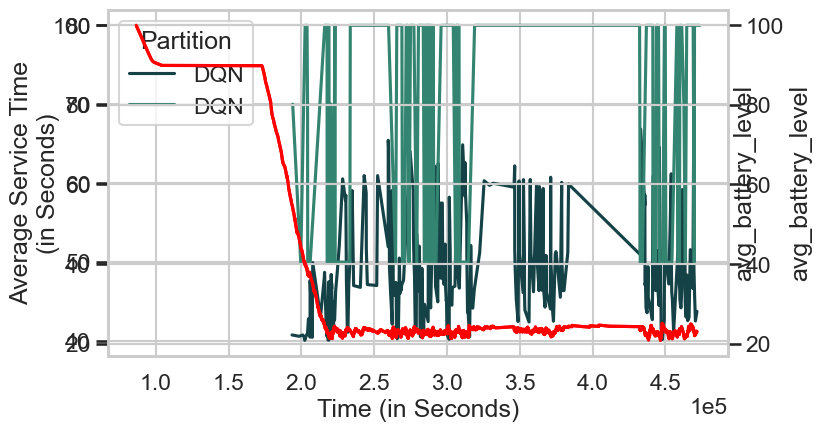

In [202]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
for df in dfs_d_actions[0]:
    ax = sns.lineplot(ax=ax, x='kpi__makespan', y='Action', 
                        label="DQN", color=next(palette), data=df)
    ax2 = plt.twinx()
    sns.lineplot(data=dfs_d[0][0], x='kpi__makespan', y='avg_battery_level', color="red", ax=ax2)
    ax.legend(title='Partition')
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Time (in Seconds)')
    ax.set_ylabel('Average Service Time\n(in Seconds)')

Text(0, 0.5, 'Average Service Time\n(in Seconds)')

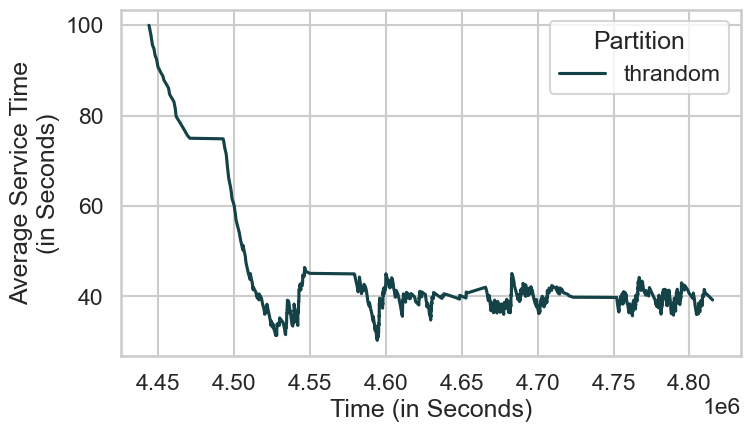

In [203]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
ax = sns.lineplot(ax=ax, x='kpi__makespan', y='avg_battery_level', 
                    label=dfs_d[12][8].name, color=next(palette), data=dfs_d[12][8])

ax.legend(title='Partition')
#ax.set_xlim((-5000, xlim + 20000))
ax.set_xlabel('Time (in Seconds)')
ax.set_ylabel('Average Service Time\n(in Seconds)')

Text(0, 0.5, 'Average Service Time\n(in Seconds)')

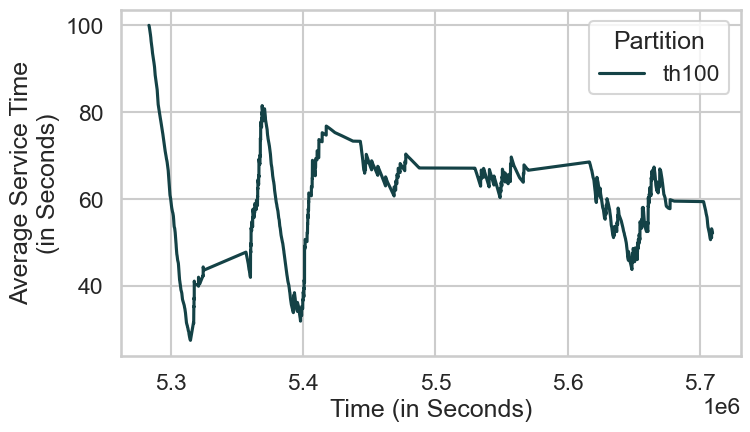

In [204]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
ax = sns.lineplot(ax=ax, x='kpi__makespan', y='avg_battery_level', 
                    label=dfs_d[14][7].name, color=next(palette), data=dfs_d[14][7])

ax.legend(title='Partition')
#ax.set_xlim((-5000, xlim + 20000))
ax.set_xlabel('Time (in Seconds)')
ax.set_ylabel('Average Service Time\n(in Seconds)')

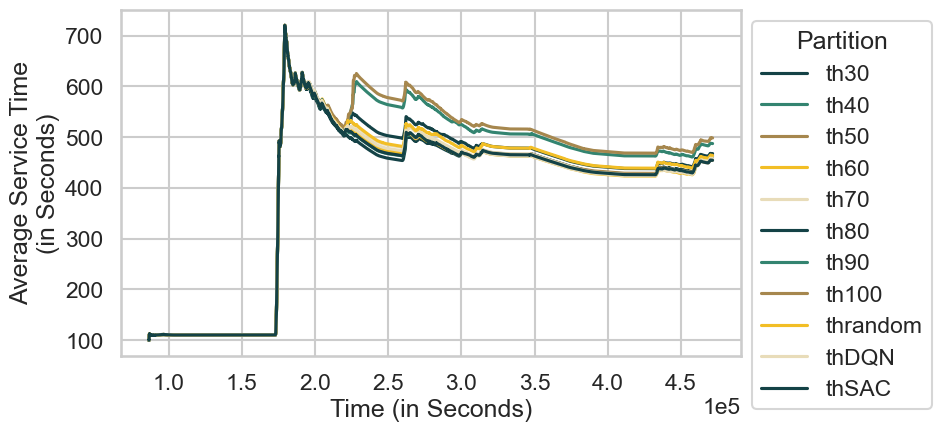

In [205]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
for df in dfs_d[0]:
    ax = sns.lineplot(ax=ax, x='kpi__makespan', y='kpi__average_service_time', 
                        label=df.name, color=next(palette), data=df)
    
    ax.legend(title='Partition')
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Time (in Seconds)')
    ax.set_ylabel('Average Service Time\n(in Seconds)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

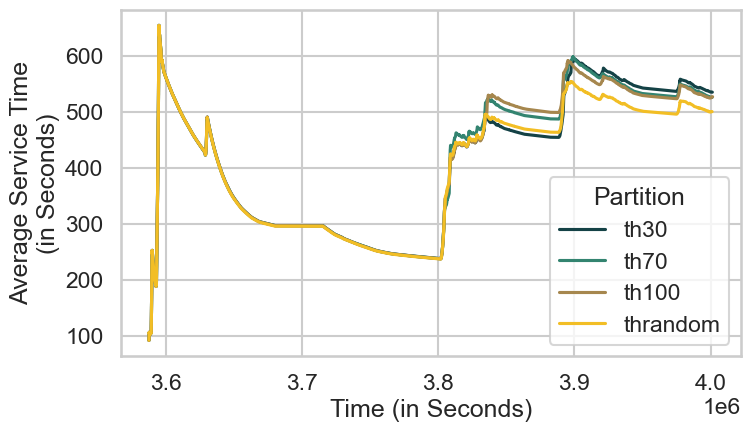

In [206]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
for idx in [0, 4, 7, 8]:
    df = dfs_d[10][idx]
    ax = sns.lineplot(ax=ax, x='kpi__makespan', y='kpi__average_service_time', 
                        label=df.name, color=next(palette), data=df)
    
    ax.legend(title='Partition')
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Time (in Seconds)')
    ax.set_ylabel('Average Service Time\n(in Seconds)')
    plt.savefig(f'{root_dir}/plot_avg_st_comp.png', 
                    dpi=200, bbox_inches='tight', pad_inches=0)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

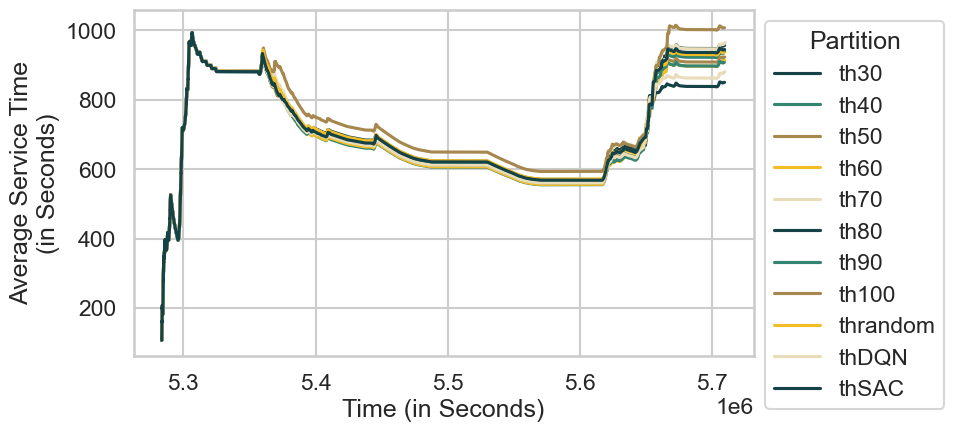

In [207]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
for df in dfs_d[14]:
    ax = sns.lineplot(ax=ax, x='kpi__makespan', y='kpi__average_service_time', 
                        label=df.name, color=next(palette), data=df)
    
    ax.legend(title='Partition')
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Time (in Seconds)')
    ax.set_ylabel('Average Service Time\n(in Seconds)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [208]:
test = deepcopy(dfs_d[10][0])

NameError: name 'deepcopy' is not defined

In [209]:
test_merge = pd.merge(test, dfs_d_actions[10][0], how="outer", on="kpi__makespan")
test_merge = test_merge.replace(np.nan,0)

NameError: name 'test' is not defined

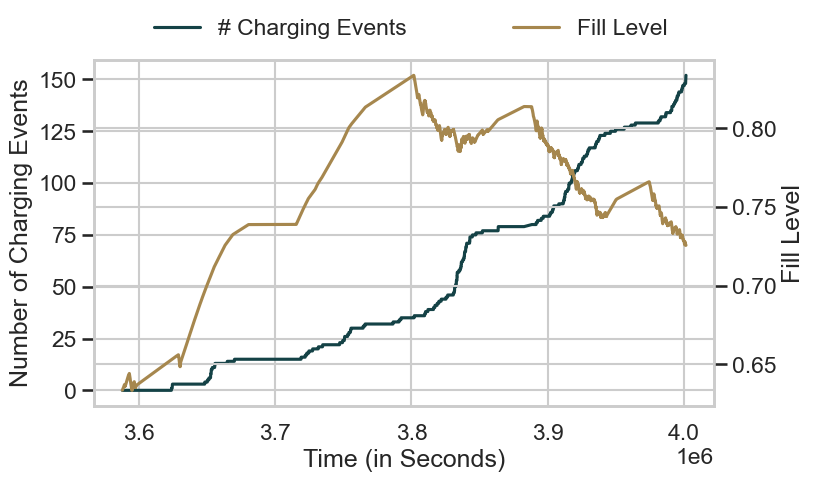

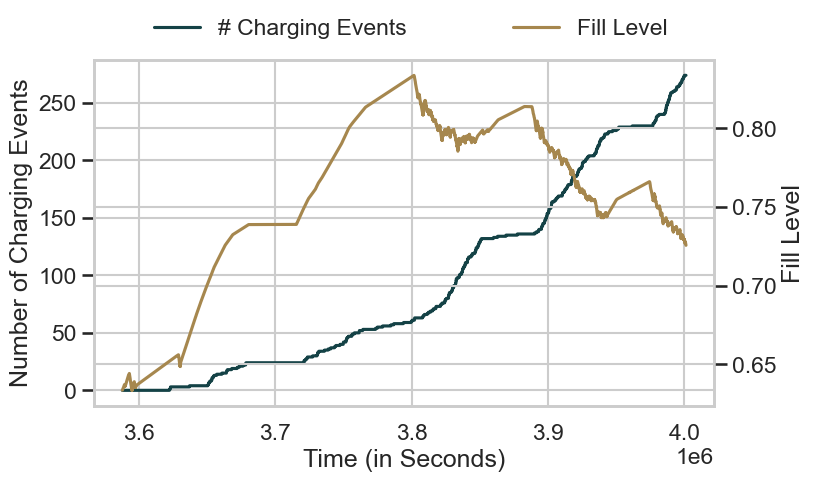

In [210]:
for i in range(2):
    _, ax = plt.subplots(figsize=(8, 4.5))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    
    palette = cycle(pal)
    idx = 10
    df = dfs_d_actions[idx][i]
    ax = sns.lineplot(ax=ax, x='kpi__makespan', y='n_charging_events', 
                        label="# Charging Events", color=next(palette), data=dfs_d[idx][i+7])
    ax2 = plt.twinx()
    sns.lineplot(data=dfs_d[idx][i+7], x='kpi__makespan', y='fill_level', label="Fill Level", color=pal[2], ax=ax2)
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Time (in Seconds)')
    ax.set_ylabel('Number of Charging Events')
    ax2.set_ylabel('Fill Level')
    if i == 0:
        model = "SAC"
    else:
        model = "DQN"
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.3, 1), ncol=1, title=None, frameon=False,)
    sns.move_legend(ax2, "lower center", bbox_to_anchor=(.8, 1), ncol=1, title=None, frameon=False,)
    plt.savefig(f'{root_dir}/plot_fill_vs_charging_events_{model}.png', 
                    dpi=200, bbox_inches='tight', pad_inches=0)

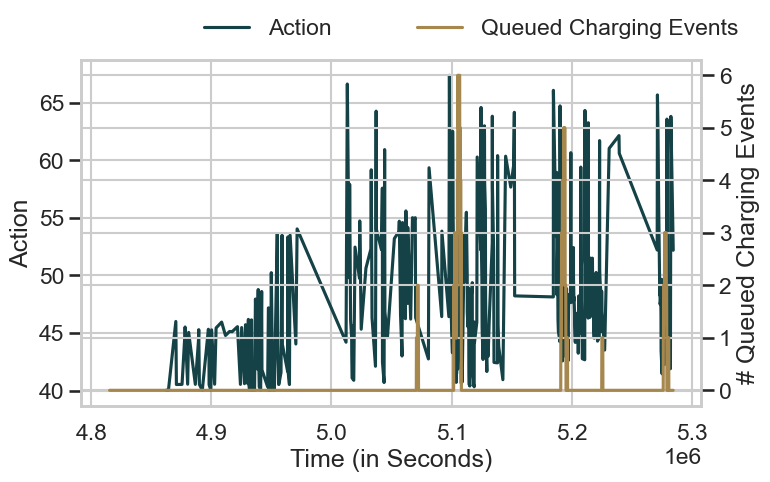

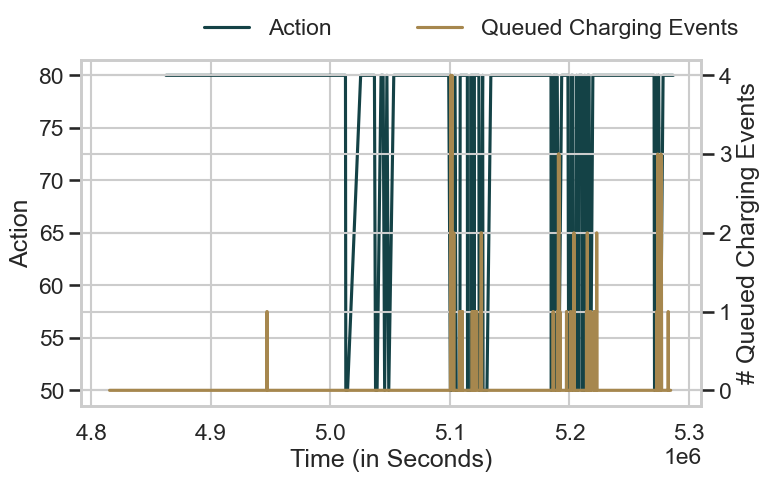

In [211]:
for i, model in enumerate(["SAC", "DQN"]):
    _, ax = plt.subplots(figsize=(8, 4.5))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    
    palette = cycle(pal)
    idx = 13
    df = dfs_d_actions[idx][i]
    ax = sns.lineplot(ax=ax, x='kpi__makespan', y='Action', 
                        label="Action", color=next(palette), data=df)
    ax2 = plt.twinx()
    sns.lineplot(data=dfs_d[idx][i+7], x='kpi__makespan', y='n_queued_charging_events', label="Queued Charging Events", color=pal[2], ax=ax2)
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Time (in Seconds)')
    ax.set_ylabel('Action')
    ax2.set_ylabel('# Queued Charging Events')
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.3, 1), ncol=1, title=None, frameon=False,)
    sns.move_legend(ax2, "lower center", bbox_to_anchor=(.8, 1), ncol=1, title=None, frameon=False,)
    plt.savefig(f'{root_dir}/plot_charging_queue_vs_charging_actions_{model}.png', 
                    dpi=200, bbox_inches='tight', pad_inches=0)

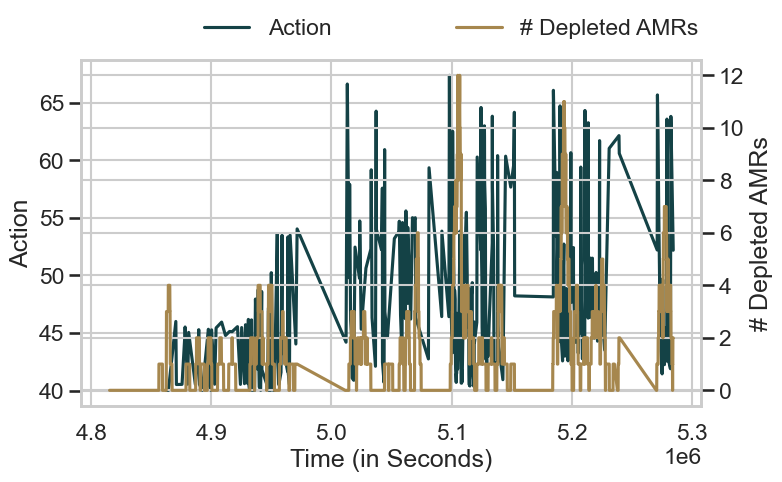

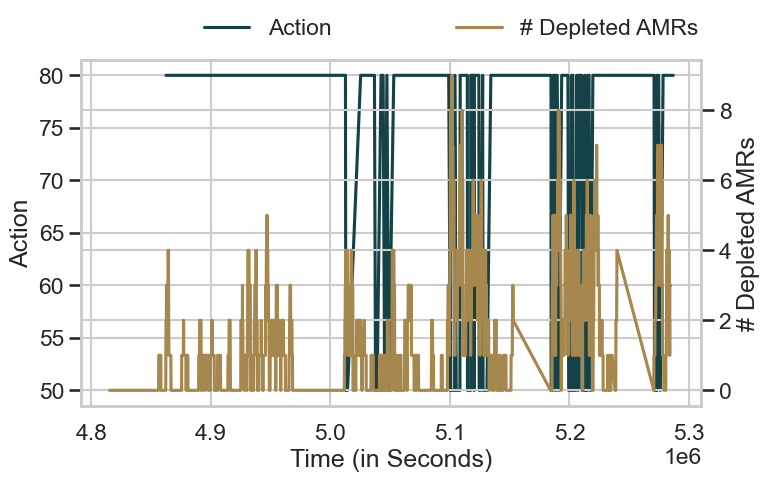

In [212]:
for i, model in enumerate(["SAC", "DQN"]):
    _, ax = plt.subplots(figsize=(8, 4.5))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    
    palette = cycle(pal)
    idx = 13
    df = dfs_d_actions[idx][i]
    ax = sns.lineplot(ax=ax, x='kpi__makespan', y='Action', 
                        label="Action", color=next(palette), data=df)
    ax2 = plt.twinx()
    sns.lineplot(data=dfs_d[idx][i+7], x='kpi__makespan', y='n_agv_depleted', label="# Depleted AMRs", color=pal[2], ax=ax2)
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Time (in Seconds)')
    ax.set_ylabel('Action')
    ax2.set_ylabel('# Depleted AMRs')
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.3, 1), ncol=1, title=None, frameon=False,)
    sns.move_legend(ax2, "lower center", bbox_to_anchor=(.8, 1), ncol=1, title=None, frameon=False,)
    plt.savefig(f'{root_dir}/plot_n_depleted_vs_charging_actions_{model}.png', 
                    dpi=200, bbox_inches='tight', pad_inches=0)

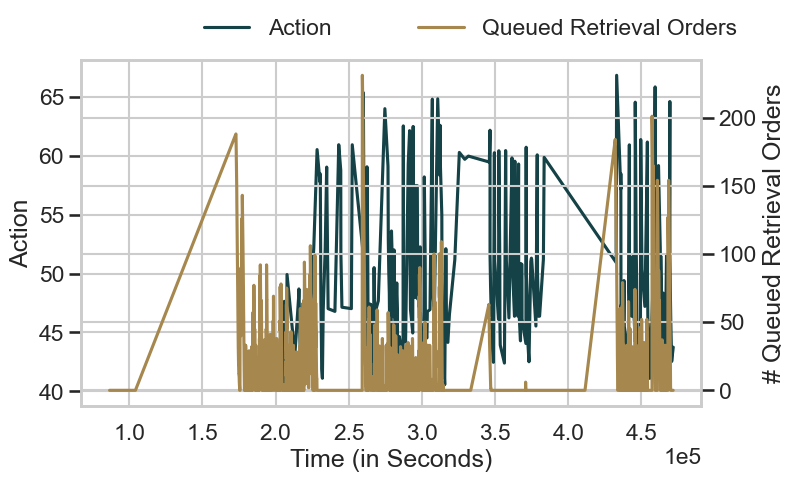

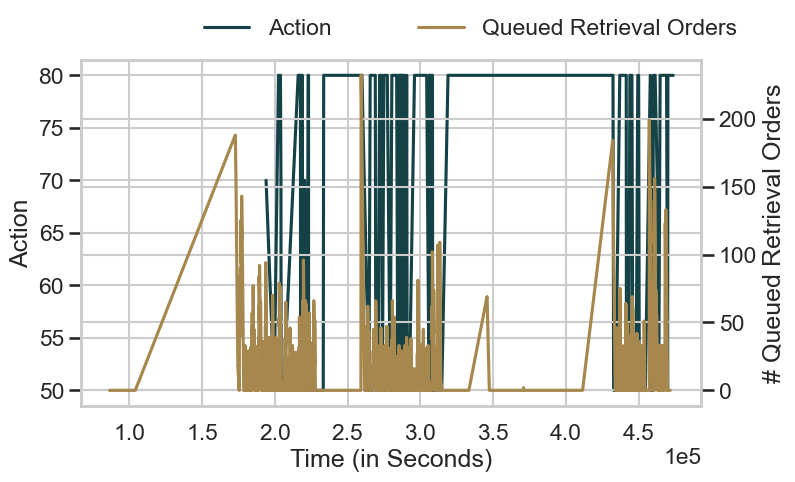

In [213]:
for i, model in enumerate(["SAC", "DQN"]):
    _, ax = plt.subplots(figsize=(8, 4.5))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    
    palette = cycle(pal)
    idx = 0
    df = dfs_d_actions[idx][i]
    ax = sns.lineplot(ax=ax, x='kpi__makespan', y='Action', 
                        label="Action", color=next(palette), data=df)
    ax2 = plt.twinx()
    sns.lineplot(data=dfs_d[idx][i+7], x='kpi__makespan', y='n_queued_retrieval_orders', label="Queued Retrieval Orders", color=pal[2], ax=ax2)
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Time (in Seconds)')
    ax.set_ylabel('Action')
    ax2.set_ylabel('# Queued Retrieval Orders')
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.3, 1), ncol=1, title=None, frameon=False,)
    sns.move_legend(ax2, "lower center", bbox_to_anchor=(.8, 1), ncol=1, title=None, frameon=False,)
    plt.savefig(f'{root_dir}/plot_queue_vs_charging_actions_{model}.png', 
                    dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
dfs_d_actions[0][1]

In [ ]:
dfs_d[0][0].columns

In [ ]:
for i in [0, 4, 7, 8]:
    _, ax = plt.subplots(figsize=(8, 4.5))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    
    palette = cycle(pal)
    idx = 10
    df = dfs_d[idx][i]
    ax = sns.lineplot(ax=ax, x='kpi__makespan', y='n_agv_depleted', 
                        label="# AGV depleted", color=next(palette), data=df)
    ax2 = plt.twinx()
    sns.lineplot(data=df, x='kpi__makespan', y='avg_battery_level', label="Avg Battery Level", color=pal[2], ax=ax2)
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Time (in Seconds)')
    ax.set_ylabel('# AGV depleted')
    ax2.set_ylabel('Avg Battery Level')
    if i == 0:
        model = "SAC"
    else:
        model = "DQN"
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.3, 1), ncol=1, title=None, frameon=False,)
    sns.move_legend(ax2, "lower center", bbox_to_anchor=(.8, 1), ncol=1, title=None, frameon=False,)
    plt.savefig(f'{root_dir}/plot_depleted_vs_battery_{df.name}.png', 
                    dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
idx = 10
df = dfs_d_actions[idx][i]
ax = sns.lineplot(ax=ax, x='kpi__makespan', y='avg_battery_level', 
                    label="Avg Battery Level", color=next(palette), data=dfs_d[idx][4])
ax2 = plt.twinx()
sns.lineplot(data=dfs_d[idx][4], x='kpi__makespan', y='n_queued_retrieval_orders', label="Fill Level", color=pal[2], ax=ax2)
#ax.set_xlim((-5000, xlim + 20000))
ax.set_xlabel('Time (in Seconds)')
ax.set_ylabel('Action')
ax2.set_ylabel('# Queued Retrieval Orders')
if i == 0:
    model = "SAC"
else:
    model = "DQN"
sns.move_legend(ax, "lower center", bbox_to_anchor=(.3, 1), ncol=1, title=None, frameon=False,)
sns.move_legend(ax2, "lower center", bbox_to_anchor=(.8, 1), ncol=1, title=None, frameon=False,)

In [ ]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
palette = cycle(pal)
idx = 10
for i in [4, 7, 8]:
    #df = dfs_d_actions[idx][i]
    df = dfs_d[idx][i]
    ax = sns.lineplot(ax=ax, x='kpi__makespan', y='avg_battery_level', 
                    label=df.name, color=next(palette), data=df)

ax2 = plt.twinx()
sns.lineplot(data=dfs_d[idx][i], x='kpi__makespan', y='n_queued_retrieval_orders', label="Fill Level", color=pal[4], ax=ax2)
#ax.set_xlim((-5000, xlim + 20000))
ax.set_xlabel('Time (in Seconds)')
ax.set_ylabel('Action')
ax2.set_ylabel('# Queued Retrieval Orders')
if i == 0:
    model = "SAC"
else:
    model = "DQN"
sns.move_legend(ax, "lower center", bbox_to_anchor=(.3, 1), ncol=1, title=None, frameon=False,)
sns.move_legend(ax2, "lower center", bbox_to_anchor=(.8, 1), ncol=1, title=None, frameon=False,)
    # plt.savefig(f'{root_dir}/plot_retrieval_vs_battery_{model}.png', 
    #                 dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
dfs_d_actions[idx][0]["Step"].nunique()

In [ ]:
dfs_d_actions[10][1].groupby(by="Action").count()

In [ ]:
for i, model in enumerate(["SAC", "DQN"]):
    _, ax = plt.subplots(figsize=(8, 4.5))
    # ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    
    palette = cycle(pal)
    idx = 10
    df = dfs_d_actions[idx][i]
    ax = sns.histplot(ax=ax, x='Action',
                        label="# Charging Events", color=next(palette), data=df)
    # ax2 = plt.twinx()
    # sns.lineplot(data=dfs_d[idx][i+7], x='kpi__makespan', y='fill_level', label="Fill Level", color=pal[2], ax=ax2)
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Action')
    # ax2.set_ylabel('Fill Level')
    plt.savefig(f'{root_dir}/plot_dist_charging_actions_{model}.png', 
                    dpi=200, bbox_inches='tight', pad_inches=0)

In [161]:
dfs_d_actions[0][0]

,Step,Action,kpi__makespan,strategy_name,n_zones,Model,partition
0,1,50,1.949661e+05,DQN,3,DQN,0
1,2,40,1.997572e+05,DQN,3,DQN,0
2,3,50,2.008137e+05,DQN,3,DQN,0
3,4,40,2.016316e+05,DQN,3,DQN,0
4,5,40,2.017612e+05,DQN,3,DQN,0
...,...,...,...,...,...,...,...
7329,412,40,3.586606e+06,DQN,3,DQN,0
7330,413,40,3.586646e+06,DQN,3,DQN,0
7331,414,40,3.587332e+06,DQN,3,DQN,0
7332,415,80,3.587637e+06,DQN,3,DQN,0


In [160]:
dfs_d_actions[5][0]

,Step,Action,kpi__makespan,strategy_name,n_zones,Model,partition
0,1,50,1.949661e+05,DQN,3,DQN,5
1,2,40,1.997572e+05,DQN,3,DQN,5
2,3,50,2.008137e+05,DQN,3,DQN,5
3,4,40,2.016316e+05,DQN,3,DQN,5
4,5,40,2.017612e+05,DQN,3,DQN,5
...,...,...,...,...,...,...,...
7329,412,40,3.586606e+06,DQN,3,DQN,5
7330,413,40,3.586646e+06,DQN,3,DQN,5
7331,414,40,3.587332e+06,DQN,3,DQN,5
7332,415,80,3.587637e+06,DQN,3,DQN,5


In [11]:
df_result_actions = pd.DataFrame()
for idx_df in partitions: 
    for idx_m, model in enumerate(["DQN"]):
        df = dfs_d_actions[idx_df][idx_m]
        df["Model"] = model
        df["partition"] = idx_df
        df_result_actions = pd.concat([df_result_actions, df])
    

In [12]:
df_result_actions_grouped = df_result_actions.groupby(by=["partition", "strategy_name"]).agg({"Action": "mean"}).reset_index()

In [13]:
df_result_actions_grouped

,partition,strategy_name,Action
0,0,SAC,48.416284
1,1,SAC,49.108995
2,2,SAC,47.765335
3,3,SAC,46.688805
4,4,SAC,49.396006
5,5,SAC,48.125212
6,6,SAC,51.388155
7,7,SAC,47.551909
8,8,SAC,50.718103
9,9,SAC,48.146313


In [14]:
df_result_actions[(df_result_actions.partition == 10) & (df_result_actions.strategy_name == "DQN")]

,Unnamed: 0,Step,Action,kpi__makespan,strategy_name,Model,partition


ValueError: Could not interpret value `Model` for `hue`. An entry with this name does not appear in `data`.

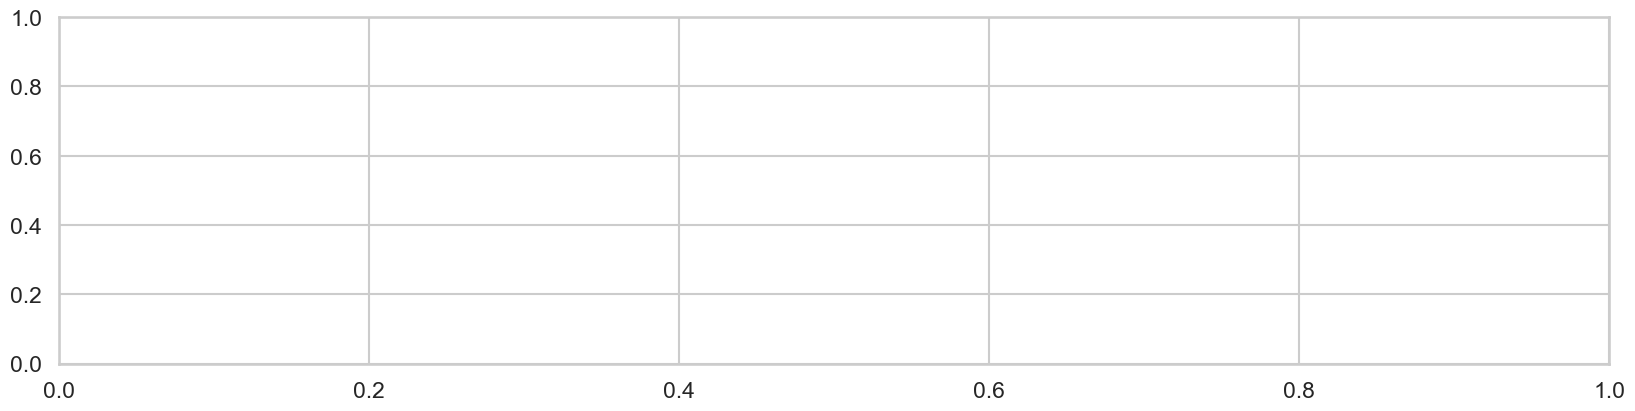

In [15]:
_, ax = plt.subplots(figsize=(20, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.barplot(ax=ax, x="partition", y="Action", data=df_result_actions_grouped, hue="Model")

In [16]:
df_result_actions

,Unnamed: 0,Step,Action,kpi__makespan,strategy_name,Model,partition
0,0,1,40.766160,193580.2,SAC,DQN,0
1,0,2,40.596554,198511.7,SAC,DQN,0
2,0,3,40.762444,200976.7,SAC,DQN,0
3,0,4,40.565650,201733.2,SAC,DQN,0
4,0,5,40.083330,202345.9,SAC,DQN,0
...,...,...,...,...,...,...,...
350,0,351,47.089230,7642916.0,SAC,DQN,19
351,0,352,46.399890,7643040.7,SAC,DQN,19
352,0,353,45.155663,7643462.0,SAC,DQN,19
353,0,354,45.091217,7653826.7,SAC,DQN,19


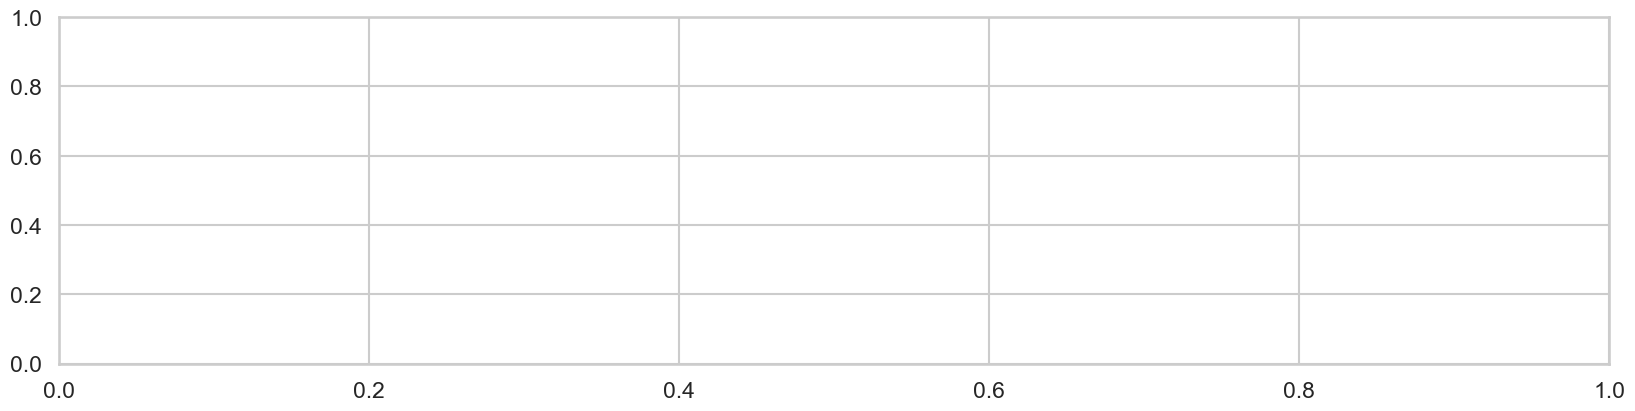

In [17]:
_, ax = plt.subplots(figsize=(20, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle([pal[0], pal[3]])
ax = sns.violinplot(ax=ax, x="partition", y="Action", data=df_result_actions[df_result_actions["Model"]=="SAC"], color=pal[3])

plt.savefig(f'{root_dir}/violinplot_dist_charging_actions_SAC.png', 
                    dpi=200, bbox_inches='tight', pad_inches=0)

In [18]:
df_result_actions

,Unnamed: 0,Step,Action,kpi__makespan,strategy_name,Model,partition
0,0,1,40.766160,193580.2,SAC,DQN,0
1,0,2,40.596554,198511.7,SAC,DQN,0
2,0,3,40.762444,200976.7,SAC,DQN,0
3,0,4,40.565650,201733.2,SAC,DQN,0
4,0,5,40.083330,202345.9,SAC,DQN,0
...,...,...,...,...,...,...,...
350,0,351,47.089230,7642916.0,SAC,DQN,19
351,0,352,46.399890,7643040.7,SAC,DQN,19
352,0,353,45.155663,7643462.0,SAC,DQN,19
353,0,354,45.091217,7653826.7,SAC,DQN,19


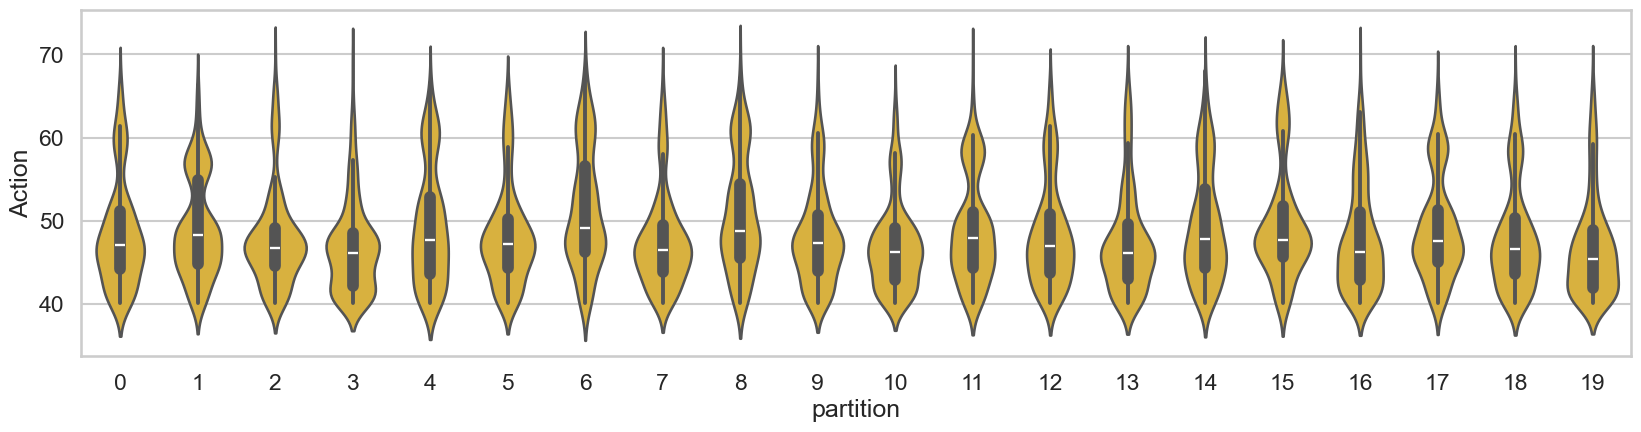

In [19]:
_, ax = plt.subplots(figsize=(20, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle([pal[0], pal[3]])
ax = sns.violinplot(ax=ax, x="partition", y="Action", data=df_result_actions[df_result_actions["Model"]=="DQN"], color=pal[3])

plt.savefig(f'{root_dir}/violinplot_dist_charging_actions_DQN.png', 
                    dpi=200, bbox_inches='tight', pad_inches=0)

IndexError: list index out of range

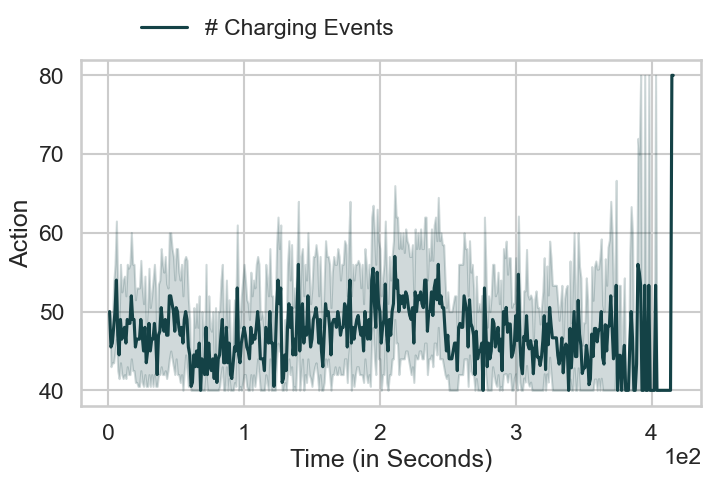

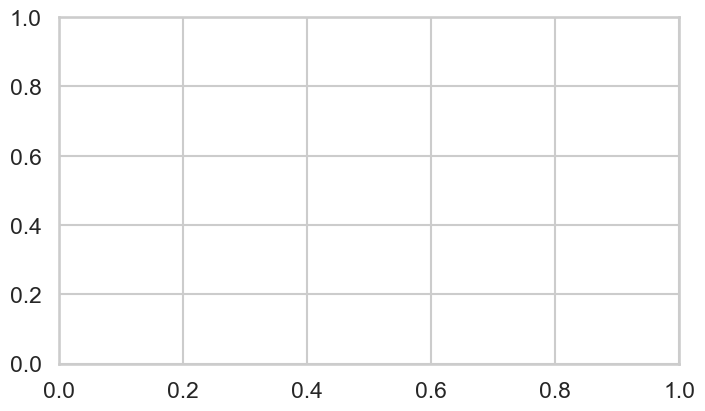

In [60]:
for i in range(2):
    _, ax = plt.subplots(figsize=(8, 4.5))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    
    palette = cycle(pal)
    idx = 10
    df = dfs_d_actions[idx][i]
    ax = sns.lineplot(ax=ax, x='Step', y='Action', 
                        label="# Charging Events", color=next(palette), data=df)
    # ax2 = plt.twinx()
    # sns.lineplot(data=dfs_d[idx][i+7], x='kpi__makespan', y='fill_level', label="Fill Level", color=pal[2], ax=ax2)
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Time (in Seconds)')
    ax.set_ylabel('Action')
    # ax2.set_ylabel('Fill Level')
    if i == 0:
        model = "SAC"
    else:
        model = "DQN"
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.3, 1), ncol=1, title=None, frameon=False,)
    # sns.move_legend(ax2, "lower center", bbox_to_anchor=(.8, 1), ncol=1, title=None, frameon=False,)
    # plt.savefig(f'{root_dir}/plot_fill_vs_charging_actions_{model}.png', 
    #                 dpi=200, bbox_inches='tight', pad_inches=0)

In [21]:
dfs_d_actions[1][0]["ChargingEvent"] = 1
dfs_d_actions[1][1]["ChargingEvent"] = 1

In [22]:
def convert_time(row, time_col):
    return pd.Timestamp(row[time_col], unit='s') 

In [23]:
dfs_d_actions[10][0]["time"] = dfs_d_actions[10][0].apply(lambda x: convert_time(x), axis=1)

TypeError: convert_time() missing 1 required positional argument: 'time_col'

In [24]:
dfs_d_actions[10][0]["time"] = dfs_d_actions[10][0]["time"].apply(lambda x: x.strftime("%Y-%m-%d"))

KeyError: 'time'

In [ ]:
from copy import deepcopy
test = deepcopy(dfs_d_actions[10][1])
test["time"] = dfs_d_actions[10][1].apply(lambda x: convert_time(x, "kpi__makespan"), axis=1)
test.set_index("time", inplace=True)

In [ ]:
orders_ = deepcopy(orders_dict[10][0])
orders_.set_index("arrival_datetime",inplace=True)

In [ ]:
orders_resampled = orders_.resample("D").count()
#orders_resampled.reset_index(inplace=True, drop=True)
actions_resampled = test.resample("D").count()
orders_resampled.index.rename("time", inplace=True)
orders_resampled.rename(columns={"order": "value"}, inplace=True)
actions_resampled.rename(columns={"Step": "value"}, inplace=True)
orders_resampled["value"] /= 100
df_orders_actions = pd.concat([orders_resampled[["value"]], actions_resampled[["value"]]])
df_orders_actions['source'] = ['orders'] * len(orders_resampled) + ['events'] * len(actions_resampled)
df_orders_actions

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='time', y='value', hue='source', data=df_orders_actions, palette='muted', ci=None)

plt.title('Stacked Bar Chart')
plt.xlabel('Category')
plt.ylabel('Value')
plt.legend(title='Data Frame')
plt.show()

NameError: name 'orders_resampled' is not defined

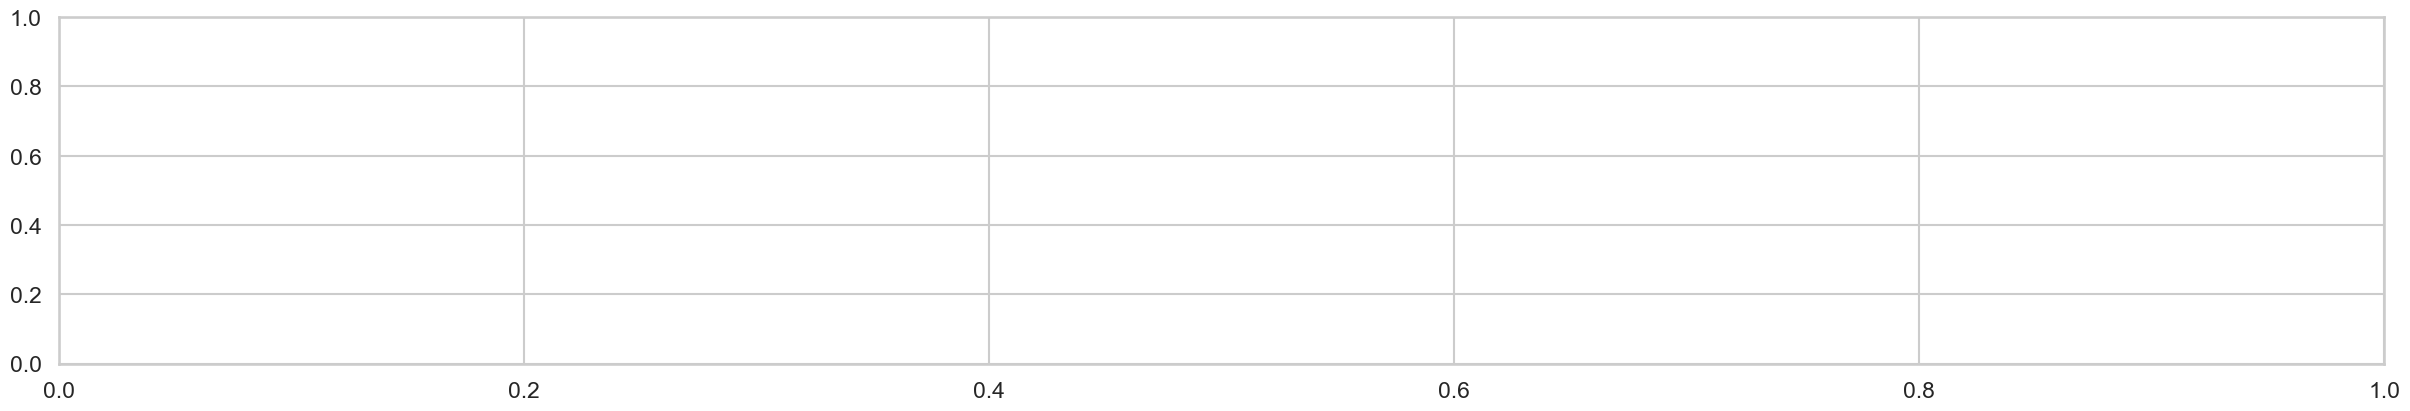

In [20]:
_, ax = plt.subplots(figsize=(30, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
ax = sns.barplot(ax=ax, x='arrival_datetime', y='order', 
                    label="", color=pal[0], lw=0., data=orders_resampled)
ax2 = plt.twinx()
sns.barplot(data=actions_resampled, x='time', y='Step', color=pal[2], lw=0., ax=ax2)
#ax.set_xlim((-5000, xlim + 20000))
ax.set_ylabel('Number of Orders')
ax2.set_ylabel('Number of Charging Events')
x_dates = orders_resampled.index.weekday
ax.set_xticklabels(x_dates, rotation=90, ha='right')
ax.set_xlabel('Time (in Hours)')
plt.savefig(f'{root_dir}/barplot_orders_vs_charging_events.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
orders_resampled

In [61]:
orders_resampled = orders_dict[10][0].resample("10T").count()
actions_resampled = test.resample("10T").count()

_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
ax = sns.lineplot(ax=ax, x='time', y='Step', 
                    label="", color=next(palette), data=actions_resampled)
# ax2 = plt.twinx()
# sns.lineplot(data=actions_resampled, x='time', y='Step', color=next(palette), ax=ax2)
#ax.set_xlim((-5000, xlim + 20000))
ax.set_xlabel('Time (in Seconds)')
ax.set_ylabel('Number of Charging Events')
plt.savefig(f'{root_dir}/plot_orders_vs_charging_events_ce.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [ ]:
orders_resampled.reset_index(inplace=True)
orders_resampled.rename(columns={"arrival_datetime":"time", "order": "Step"}, inplace=True)

In [ ]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
for df in [orders_resampled, actions_resampled]:
    ax = sns.lineplot(ax=ax, x='time', y='Step', 
                        label="", color=next(palette), data=df)
    # ax2 = plt.twinx()
    # sns.lineplot(data=dfs_d[10][0], x='kpi__makespan', y='n_agv_depleted', color="red", ax=ax2)
    ax.legend(title='Partition')
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Time (in Seconds)')
    ax.set_ylabel('Average Service Time\n(in Seconds)')

In [ ]:
orders_dict[10][0]

Text(0, 0.5, 'Number of Charging Events')

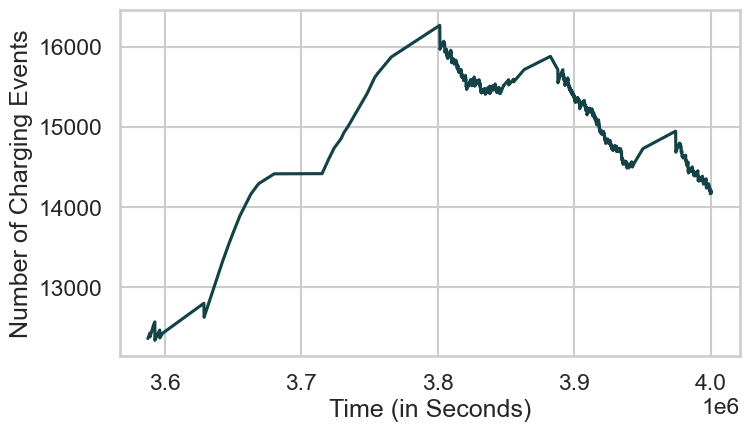

In [178]:
_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

palette = cycle(pal)
ax = sns.lineplot(ax=ax, x='arrival', y='current_stock_overall', 
                    label="", color=next(palette), data=orders_dict[10][0])
# ax2 = plt.twinx()
# sns.lineplot(data=actions_resampled, x='time', y='Step', color=next(palette), ax=ax2)
#ax.set_xlim((-5000, xlim + 20000))
ax.set_xlabel('Time (in Seconds)')
ax.set_ylabel('Number of Charging Events')
# plt.savefig(f'{root_dir}/plot_orders_vs_charging_events_ce.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

NameError: name 'dfs_comp' is not defined

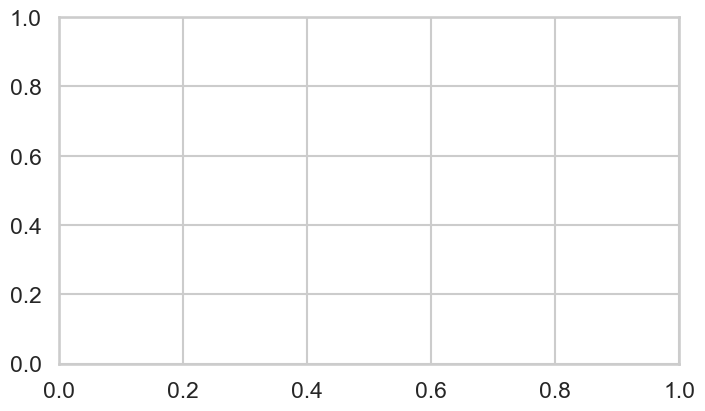

In [94]:
from copy import deepcopy

def plot_constraints(indicator, limit, y_label):
    _, ax = plt.subplots(figsize=(8, 4.5))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    
    palette = cycle(pal)
    xlim = 0
    for i in reversed(list(dfs_comp.keys())):
        for df in dfs_comp[i]:
            df_parametrization_check = deepcopy(df)
            samples = df_parametrization_check.sample(min(500,df_parametrization_check.shape[0]))
            # if n_agv == 7:
            #     xlim = df_parametrization_check['kpi__makespan'].max() 
            #     print(xlim)
            name = None
            if n_cs == 0:
                name = "Lower Bound"
            else:
                name = n_cs
            ax = sns.lineplot(
                ax=ax, x=samples['kpi__makespan'], y=samples[indicator], 
                label=name, color=next(palette))

            df_parametrization_check['n_cs'] = [n_cs] * df.shape[0]
    if limit:
        ax.axhline(limit, 
                   color='red', linestyle='dashdot', label='Limit') 

    ax.legend(title='CS Number')
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Time (in Seconds)')
    ax.set_ylabel(y_label)

    plt.savefig(f'{root_dir}/constraints__{indicator}.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()

plot_constraints('kpi__average_service_time', limit=600, y_label='Average Service Time\n(in Seconds)')
plot_constraints('n_queued_retrieval_orders', limit=330, y_label='N Queued Retrieval Orders')
plot_constraints('n_queued_delivery_orders', limit=240, y_label='N Queued Delivery Orders')
plot_constraints('n_agv_depleted', limit=None, y_label='N Depleted AMRs')

In [ ]:
#ccheck_df.reset_index(drop=True)

### 3. Reuslts <a id='res'>

[Back to Overview](#ov)

3.1 Threshold Comparison

In [23]:
dfs_d[19]

[       total_distance  average_distance  travel_time_retrieval_ave  \
 0               144.8         36.200000                   0.000000   
 1               244.6         48.920000                   0.000000   
 2               345.4         57.566667                   0.000000   
 3               788.6         60.661538                   0.000000   
 4               907.4         60.493333                   0.000000   
 ...               ...               ...                        ...   
 20586       3912736.4         81.452555                 117.545024   
 20587       3912924.2         81.454769                 117.551092   
 20588       3913130.2         81.453971                 117.550744   
 20589       3913507.2         81.456731                 117.550643   
 20590       3913728.2         81.457940                 117.552700   
 
        distance_retrieval_ave  total_shift_distance  utilization_time  \
 0                    0.000000                   0.0      3.522835e-07  

In [11]:
def gen_result_table(dfs_d, value, mode):
    list_of_dfs = []
    for idx in partitions:
        print("Loading partition", idx)
        #print(idx)
        df_results_pt = pd.DataFrame(columns=[f"{idx}"])
        for df in dfs_d[idx]:
            #print(df.name)
            #print(df["kpi__average_service_time"].mean())
            df = df.sort_values(by="kpi__makespan")
            if mode == "mean":
                row_data = pd.DataFrame(data={f"{idx}": [df[value].mean()]}) #df["kpi__makespan"].iloc[-1]]
            elif mode == "last":
                row_data = pd.DataFrame(data={f"{idx}": [float(df[value].iloc[-1].round(decimals=2))]}) #df["kpi__makespan"].iloc[-1]]
            elif mode == "max":
                row_data = pd.DataFrame(data={f"{idx}": [df[value].max()]})
            #print(df["kpi__makespan"].iloc[-1])
            df_results_pt = pd.concat([df_results_pt, row_data])
        list_of_dfs.append(df_results_pt)
        print(len(df_results_pt))
    strategy_col = pd.DataFrame(columns=["Strategy"])
    for th in thresholds:
        row = pd.DataFrame(data={"Strategy": [th]})
        strategy_col = pd.concat([strategy_col, row])
    print(strategy_col)
    result_df = pd.DataFrame()
    result_df = pd.concat([result_df, strategy_col], axis=1)
    for df in list_of_dfs:
        result_df = pd.concat([result_df, df], axis=1)
    result_df = result_df.transpose().reset_index()
    new_header = result_df.iloc[0] 
    result_df.drop(index=0, inplace=True)
    result_df.columns = new_header
    #result_df["Avg. overall"] = result_df.loc[:, [40, 50, 60, 70, 80, 90, 100, "no_battery_constraints"]].mean(axis = 1)
    result_df["Std"] = result_df.iloc[:, 1:5].std(axis = 1)
    # fill_lvl = [68, 87, 90, 77, 74, 86, 78, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    # result_df.insert(11, "Fill Level", fill_lvl, True)
    return result_df
    
thresholds = [30, 40, 50, 60, 70, 80, 90, 100, "random", "DQN", "SAC"]
result_df = gen_result_table(dfs_d, "kpi__average_service_time", "last")

Loading partition 0
11
Loading partition 1
11
Loading partition 2
11
Loading partition 3
11
Loading partition 4
11
Loading partition 5
11
Loading partition 6
11
Loading partition 7
11
Loading partition 8
11
Loading partition 9
11
Loading partition 10
11
Loading partition 11
11
Loading partition 12
11
Loading partition 13
11
Loading partition 14
11
Loading partition 15
11
Loading partition 16
11
Loading partition 17
11
Loading partition 18
11
Loading partition 19
11
  Strategy
0       30
0       40
0       50
0       60
0       70
0       80
0       90
0      100
0   random
0      DQN
0      SAC


In [12]:
result_df

,Strategy,30,40,50,60,70,80,90,100,random,DQN,SAC,Std
1,0,467.14,461.84,454.52,464.26,463.82,467.51,487.45,498.47,464.17,458.03,454.51,5.400272
2,1,607.84,610.55,579.53,584.03,578.96,577.41,587.28,595.99,611.72,574.96,601.81,15.972677
3,2,599.4,579.96,626.64,639.3,660.59,703.74,810.09,868.68,619.66,584.74,608.83,26.727755
4,3,539.65,545.67,536.46,494.66,497.63,490.31,495.06,491.61,511.76,515.28,554.69,23.281969
5,4,491.15,484.36,496.03,485.93,530.11,543.8,595.58,622.42,502.05,509.73,491.39,5.305898
6,5,560.04,553.04,542.45,541.96,570.77,564.57,558.33,555.36,568.93,554.49,569.03,8.758087
7,6,686.6,677.68,679.48,679.51,706.23,686.68,704.7,711.29,665.46,692.45,692.08,3.948826
8,7,622.63,616.61,581.86,607.59,570.15,833.31,595.47,568.01,577.25,582.06,598.48,17.971252
9,8,605.7,606.2,575.81,602.99,589.98,550.11,566.68,545.23,588.06,555.96,593.01,14.644723
10,9,503.7,502.31,497.16,505.66,499.96,507.5,512.86,490.62,493.45,489.28,497.37,3.634789


In [26]:
result_melt = pd.melt(result_df, id_vars=["Strategy"], value_vars=[30, 40, 50, 60, 70, 80, 90, 100, "random", "DQN", "SAC"], var_name="Threshold")
#[40, 50, 60, 70, 80, "dqn", "sac", "no_battery_constraints"]

In [27]:
def gen_latex_tabel(subset_min, th_comp_df):
    th_comp_df.rename(columns={"lower_bound": "Lower Bound",
                       "Strategy": "Partition"}, inplace=True)
    
    th_comp_df = th_comp_df.set_index("Partition")
    
    round = th_comp_df.columns
    
    if "Std" in th_comp_df.columns:
        th_comp_view = th_comp_df.style.highlight_min(subset=subset_min, axis=1, props="font-weight:bold;").format({
         (val): '{:.2f}' for val in round}).text_gradient(cmap="rainbow", subset="Std", vmin=0, vmax=10)
    else:
        th_comp_view = th_comp_df.style.highlight_min(subset=subset_min, axis=1, props="font-weight:bold;").format({
         (val): '{:.2f}' for val in round})
    latex_string = th_comp_view.to_latex(convert_css=True, hrules=True)
    return latex_string

In [28]:
th_comp_df = result_df[["Strategy", 30, 40, 50, 60, 70, 80, 90, 100, "random", "DQN", "SAC", "Std"]]
th_comp_df.rename(columns={"Strategy": "Partition"}, inplace=True)

th_comp_df = th_comp_df.set_index("Partition")
subset_min = [
    30, 40, 50, 60, 70, 80, 90, 100, "random", "DQN", "SAC"
]

round = [
    30, 40, 50, 60, 70, 80, 90, 100, "random", "DQN", "SAC", "Std"
]

th_comp_view = th_comp_df.style.highlight_min(subset=subset_min, axis=1, props="font-weight:bold;").format({
 (val): '{:.2f}' for val in round}).text_gradient(cmap="rainbow", subset="Std", vmin=0, vmax=10)
latex_string = th_comp_view.to_latex(convert_css=True, hrules=True)

In [29]:
subset_no_rl = [30, 40, 50, 60, 70, 80, 90, 100, "random"]
subset_rl = [30, 40, 50, 60, 70, 80, 90, 100, "random", "DQN", "SAC"]
latex_string_no_rl = gen_latex_tabel(subset_no_rl, result_df[["Strategy", 30, 40, 50, 60, 70, 80, 90, 100, "random", "Std"]])
latex_string_rl = gen_latex_tabel(subset_rl, result_df[["Strategy", 30, 40, 50, 60, 70, 80, 90, 100, "random", "DQN", "SAC"]])

C:\Users\zm0714\AppData\Local\Temp\ipykernel_28920\1397883999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  th_comp_df.rename(columns={"lower_bound": "Lower Bound",
C:\Users\zm0714\AppData\Local\Temp\ipykernel_28920\1397883999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  th_comp_df.rename(columns={"lower_bound": "Lower Bound",


In [30]:
print(type(latex_string_no_rl), '\n', latex_string_no_rl)

<class 'str'> 
 \begin{tabular}{lllllllllll}
\toprule
0 & 30 & 40 & 50 & 60 & 70 & 80 & 90 & 100 & random & Std \\
Partition &  &  &  &  &  &  &  &  &  &  \\
\midrule
0 & 467.14 & 461.84 & \bfseries 454.52 & 464.26 & 463.82 & 467.51 & 487.45 & 498.47 & 464.17 & \color[HTML]{94FDA8} 5.40 \\
1 & 607.84 & 610.55 & 579.53 & 584.03 & 578.96 & \bfseries 577.41 & 587.28 & 595.99 & 611.72 & \color[HTML]{FF0000} 15.97 \\
2 & 599.40 & \bfseries 579.96 & 626.64 & 639.30 & 660.59 & 703.74 & 810.09 & 868.68 & 619.66 & \color[HTML]{FF0000} 26.73 \\
3 & 539.65 & 545.67 & 536.46 & 494.66 & 497.63 & \bfseries 490.31 & 495.06 & 491.61 & 511.76 & \color[HTML]{FF0000} 23.28 \\
4 & 491.15 & \bfseries 484.36 & 496.03 & 485.93 & 530.11 & 543.80 & 595.58 & 622.42 & 502.05 & \color[HTML]{8EFEAC} 5.31 \\
5 & 560.04 & 553.04 & 542.45 & \bfseries 541.96 & 570.77 & 564.57 & 558.33 & 555.36 & 568.93 & \color[HTML]{FF5F30} 8.76 \\
6 & 686.60 & 677.68 & 679.48 & 679.51 & 706.23 & 686.68 & 704.70 & 711.29 & \bfseries 

In [31]:
print(type(latex_string_rl), '\n', latex_string_rl)

<class 'str'> 
 \begin{tabular}{llllllllllll}
\toprule
0 & 30 & 40 & 50 & 60 & 70 & 80 & 90 & 100 & random & DQN & SAC \\
Partition &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
0 & 467.14 & 461.84 & 454.52 & 464.26 & 463.82 & 467.51 & 487.45 & 498.47 & 464.17 & 458.03 & \bfseries 454.51 \\
1 & 607.84 & 610.55 & 579.53 & 584.03 & 578.96 & 577.41 & 587.28 & 595.99 & 611.72 & \bfseries 574.96 & 601.81 \\
2 & 599.40 & \bfseries 579.96 & 626.64 & 639.30 & 660.59 & 703.74 & 810.09 & 868.68 & 619.66 & 584.74 & 608.83 \\
3 & 539.65 & 545.67 & 536.46 & 494.66 & 497.63 & \bfseries 490.31 & 495.06 & 491.61 & 511.76 & 515.28 & 554.69 \\
4 & 491.15 & \bfseries 484.36 & 496.03 & 485.93 & 530.11 & 543.80 & 595.58 & 622.42 & 502.05 & 509.73 & 491.39 \\
5 & 560.04 & 553.04 & 542.45 & \bfseries 541.96 & 570.77 & 564.57 & 558.33 & 555.36 & 568.93 & 554.49 & 569.03 \\
6 & 686.60 & 677.68 & 679.48 & 679.51 & 706.23 & 686.68 & 704.70 & 711.29 & \bfseries 665.46 & 692.45 & 692.08 \\
7 & 622.63 & 616.61 & 581

In [32]:
# subset_no_rl = [40, 50, 60, 70, 80, "random"]
# subset_rl = [40, 50, 60, 70, 80, "random", "DQN", "SAC"]
# latex_string_rl_max = gen_latex_tabel(subset_rl, result_df_max)

In [33]:
# print(type(latex_string_rl_max), '\n', latex_string_rl_max)

In [34]:
result_mean = result_df[[40, 50, 60, 70, 80, "random", "DQN", "SAC"]].mean()
result_mean.rename("Mean", inplace=True)
result_std = result_df[[40, 50, 60, 70, 80, "random", "DQN", "SAC"]].std()
result_std.rename("Std", inplace=True)
result_m_s = pd.concat([result_mean, result_std], axis=1)
result_m_s.reset_index(inplace=True)
# result_std
result_m_s.rename(columns={0:"Strategy"}, inplace=True)
result_m_s = result_m_s[["Strategy", "Mean"]]
result_m_s = result_m_s.set_index("Strategy")

In [35]:
subset_min = ["Mean"]
round = ["Mean"]
result_m_s_view = result_m_s.style.highlight_min(subset=subset_min, axis=1, props="font-weight:bold;").format({
 (val): '{:.2f}' for val in round})
latex_string = result_m_s_view.to_latex(convert_css=True, hrules=True)

In [36]:
print(type(latex_string), '\n', latex_string)

<class 'str'> 
 \begin{tabular}{ll}
\toprule
 & Mean \\
Strategy &  \\
\midrule
40 & \bfseries 610.09 \\
50 & \bfseries 605.61 \\
60 & \bfseries 609.34 \\
70 & \bfseries 611.24 \\
80 & \bfseries 621.41 \\
random & \bfseries 609.59 \\
DQN & \bfseries 594.92 \\
SAC & \bfseries 614.92 \\
\bottomrule
\end{tabular}



#### 3.1 Overview Table <a id='res_table'>
[Back to Overview](#ov)

In [37]:
new_slap_names = {
    'fixed_charge': 'fixed_charge'
}

In [38]:
%%time

Result = namedtuple('Result', [
    'total_distance', 
#     'average_distance',
#     'travel_time_retrieval_ave',
    'total_shift_distance',
    'distance_retrieval_ave', 
    'utilization_time',
    'makespan', 
    'cycle_time', 
    'entropy',
    'average_service_time', 
    'throughput', 'max_delivery_buffer', 'max_retrieval_buffer', 'mean_retrieval_buffer',
    'max_agv_depleted','mean_agv_depleted',
    'index', 'name'])

def get_best_storage_strategies(experiment_dfs, n_best, exclude, scoring='average_service_time'):
    scores = []
    idx = 0
    for df in experiment_dfs:
        if df.name in exclude:
            print(df.name)
            continue
        df_sorted = df[[
            'total_distance', 
            #'average_distance',
            #'travel_time_retrieval_ave',
            'total_shift_distance',
            'distance_retrieval_ave', 
            'utilization_time',
            'kpi__makespan', 
            'kpi__cycle_time', 
            'entropy',
            'kpi__average_service_time', 
            'kpi__throughput', 'n_finished_orders', 
            'n_queued_delivery_orders', 'n_queued_retrieval_orders', 'n_agv_depleted']
        ].sort_values('kpi__makespan')
        if df.name == "th_no_battery_constraints":
            df_sorted.name = "lower bound"
        if df.name == "dqn" or df.name == "sac":
            df_sorted.name = df.name
        else:
            df_sorted.name = df.name #.split("_")[1]
    
        end_row = df_sorted.iloc[-1,:]
        res = Result(
            end_row['total_distance'], 
            # end_row['average_distance'],
            # end_row['travel_time_retrieval_ave'],
            end_row['total_shift_distance'],
            end_row['distance_retrieval_ave'], 
            end_row['utilization_time'],
            end_row['kpi__makespan'], 
            end_row['kpi__cycle_time'],
            end_row['entropy'],
            end_row['kpi__average_service_time'], 
            end_row['kpi__throughput'],
            df_sorted['n_queued_delivery_orders'].max(),
            df_sorted['n_queued_retrieval_orders'].max(),
            df_sorted['n_queued_retrieval_orders'].mean(),
            df_sorted['n_agv_depleted'].max(),
            df_sorted['n_agv_depleted'].mean(),
            idx, df_sorted.name)
        scores.append(res)
        idx += 1
    scores_sorted = sorted(scores, key=lambda x: getattr(x,scoring))
    df_selection = []
    n_best = min(n_best, len(scores_sorted))
    print(n_best)
    for i in range(n_best):
        res = scores_sorted[i]
        print(res.average_service_time, i, experiment_dfs[scores_sorted[i].index].name)
        df_selection.append(experiment_dfs[scores_sorted[i].index])
    print("done")
    res_df = pd.DataFrame(data=scores_sorted)
    return df_selection, res_df

best_dfs_d = dict({})
res_overview_df_d = dict({})
for pt, dfs_s in dfs_d.items():
    print(f"Heuristic Service Time Ranks for partition {pt}:")
    best_dfs_d[pt], res_overview_df_d[pt] = get_best_storage_strategies(
        dfs_s, 5,[], 'average_service_time')

Heuristic Service Time Ranks for partition 0:
5
454.5114176972253 0 partition_0
454.5165703462664 1 partition_0
458.0290290660966 2 partition_0
461.8386097081251 3 partition_0
463.81978959254207 4 partition_0
done
Heuristic Service Time Ranks for partition 1:
5
574.9553907046769 0 partition_1
577.4071105094474 1 partition_1
578.9561622796366 2 partition_1
579.5301114564553 3 partition_1
584.0266584915738 4 partition_1
done
Heuristic Service Time Ranks for partition 2:
5
579.9620574522728 0 partition_2
584.7419115147349 1 partition_2
599.401750764884 2 partition_2
608.8283558404032 3 partition_2
619.6596304210693 4 partition_2
done
Heuristic Service Time Ranks for partition 3:
5
490.3075263464565 0 partition_3
491.6102550871584 1 partition_3
494.66294740419096 2 partition_3
495.0583525569232 3 partition_3
497.6331564761219 4 partition_3
done
Heuristic Service Time Ranks for partition 4:
5
484.3577005730722 0 partition_4
485.93255609248047 1 partition_4
491.1509913311588 2 partition_4
49

In [39]:
pt = 10
res_overview_df = res_overview_df_d[pt]
best_dfs = best_dfs_d[pt]
res_overview_df

,total_distance,total_shift_distance,distance_retrieval_ave,utilization_time,makespan,cycle_time,entropy,average_service_time,throughput,max_delivery_buffer,max_retrieval_buffer,mean_retrieval_buffer,max_agv_depleted,mean_agv_depleted,index,name
0,4056444.6,227063.2,181.430967,0.031521,4.001178e+06,2.187048e+06,0.622158,500.082588,0.005146,7,290,16.976689,9,2.033024,8,partition_10
1,4083582.2,223722.8,184.554028,0.031558,4.001377e+06,2.243099e+06,0.610244,504.375422,0.005146,7,290,16.860085,9,2.019814,9,partition_10
2,4059144.6,227726.8,182.009875,0.031538,4.001272e+06,2.158684e+06,0.622172,514.966429,0.005146,7,290,17.501190,10,2.089602,1,partition_10
3,4027085.0,228345.6,181.991125,0.031526,4.001210e+06,2.259425e+06,0.644512,517.576370,0.005146,7,290,16.760429,11,1.971104,6,partition_10
4,4002151.2,228037.6,181.282707,0.031264,4.001248e+06,2.321981e+06,0.640371,522.603567,0.005146,7,290,17.708465,11,1.917343,5,partition_10
5,4058734.8,224778.4,183.038140,0.031432,4.001164e+06,2.315432e+06,0.619504,525.371135,0.005146,7,290,17.357438,10,2.038755,4,partition_10
6,4030377.4,228102.0,182.527679,0.031614,4.001525e+06,2.256947e+06,0.638178,526.724877,0.005146,7,290,17.434899,11,2.022923,7,partition_10
7,3973812.0,227570.0,178.927083,0.031073,4.001203e+06,2.197265e+06,0.624729,531.879043,0.005146,7,290,18.404886,9,1.970181,10,partition_10
8,4086654.2,229868.8,182.820900,0.031855,4.001342e+06,2.206304e+06,0.632962,534.799224,0.005146,7,290,18.460055,11,2.324559,0,partition_10
9,4061201.8,227670.8,183.519932,0.031553,4.001217e+06,2.263004e+06,0.624746,537.909264,0.005146,7,290,18.037978,9,2.009227,3,partition_10


In [40]:
result_df = result_df.astype(float)

In [41]:
result_df.describe()

,Strategy,30,40,50,60,70,80,90,100,random,DQN,SAC,Std
count,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.00000,20.000000,20.000000
mean,9.50000,619.673500,610.085500,605.614500,609.335500,611.239000,621.406500,624.823500,637.41100,609.593500,594.91750,614.919500,11.961251
std,5.91608,150.360475,142.376476,140.101115,142.765503,145.318861,145.309615,147.083758,165.68721,147.194123,127.27087,147.373708,8.170352
min,0.00000,442.590000,448.110000,437.640000,454.220000,432.480000,437.900000,438.010000,460.70000,438.700000,432.69000,440.510000,3.041787
25%,4.75000,538.437500,532.902500,540.165000,529.847500,528.925000,537.315000,539.067500,540.60250,509.332500,513.89250,533.260000,5.376678
50%,9.50000,596.645000,582.810000,575.785000,578.315000,571.695000,570.990000,583.970000,582.00000,581.480000,565.46000,588.840000,9.909865
75%,14.25000,624.995000,612.065000,614.805000,616.372500,620.375000,690.945000,634.515000,644.63750,620.680000,593.29000,612.155000,16.472321
max,19.00000,1005.200000,940.730000,939.110000,964.190000,965.200000,937.340000,933.580000,1008.02000,974.990000,881.35000,975.590000,30.805967


In [43]:
result_df

,Strategy,30,40,50,60,70,80,90,100,random,DQN,SAC,Std
1,0.0,467.14,461.84,454.52,464.26,463.82,467.51,487.45,498.47,464.17,458.03,454.51,5.400272
2,1.0,607.84,610.55,579.53,584.03,578.96,577.41,587.28,595.99,611.72,574.96,601.81,15.972677
3,2.0,599.40,579.96,626.64,639.30,660.59,703.74,810.09,868.68,619.66,584.74,608.83,26.727755
4,3.0,539.65,545.67,536.46,494.66,497.63,490.31,495.06,491.61,511.76,515.28,554.69,23.281969
5,4.0,491.15,484.36,496.03,485.93,530.11,543.80,595.58,622.42,502.05,509.73,491.39,5.305898
6,5.0,560.04,553.04,542.45,541.96,570.77,564.57,558.33,555.36,568.93,554.49,569.03,8.758087
7,6.0,686.60,677.68,679.48,679.51,706.23,686.68,704.70,711.29,665.46,692.45,692.08,3.948826
8,7.0,622.63,616.61,581.86,607.59,570.15,833.31,595.47,568.01,577.25,582.06,598.48,17.971252
9,8.0,605.70,606.20,575.81,602.99,589.98,550.11,566.68,545.23,588.06,555.96,593.01,14.644723
10,9.0,503.70,502.31,497.16,505.66,499.96,507.50,512.86,490.62,493.45,489.28,497.37,3.634789


In [44]:
result_df_copy = result_df.copy()
res_paper_df = result_df.copy()
result_df_copy = result_df_copy.drop([30, 100], axis=1)

In [45]:
idx = 8
res_paper_df["Min"] = result_df_copy.iloc[:, 1:idx].min(axis=1)
res_paper_df["Min Strat"] = result_df_copy.iloc[:, 1:idx].idxmin(axis=1)
res_paper_df["Max"] = result_df_copy.iloc[:, 1:idx].max(axis=1)
res_paper_df["Max Strat"] = result_df_copy.iloc[:, 1:idx].idxmax(axis=1)

In [46]:
res_paper_df = res_paper_df[["Strategy", "Min", "Min Strat", "Max", "Max Strat", "DQN", "SAC"]]

In [47]:
res_paper_df

,Strategy,Min,Min Strat,Max,Max Strat,DQN,SAC
1,0.0,454.51,SAC,487.45,90,458.03,454.51
2,1.0,574.96,DQN,611.72,random,574.96,601.81
3,2.0,579.96,40,810.09,90,584.74,608.83
4,3.0,490.31,80,554.69,SAC,515.28,554.69
5,4.0,484.36,40,595.58,90,509.73,491.39
6,5.0,541.96,60,570.77,70,554.49,569.03
7,6.0,665.46,random,706.23,70,692.45,692.08
8,7.0,570.15,70,833.31,80,582.06,598.48
9,8.0,550.11,80,606.20,40,555.96,593.01
10,9.0,489.28,DQN,512.86,90,489.28,497.37


In [48]:
res_paper_df.to_latex()

'\\begin{tabular}{lrrlrlrr}\n\\toprule\n0 & Strategy & Min & Min Strat & Max & Max Strat & DQN & SAC \\\\\n\\midrule\n1 & 0.000000 & 454.510000 & SAC & 487.450000 & 90 & 458.030000 & 454.510000 \\\\\n2 & 1.000000 & 574.960000 & DQN & 611.720000 & random & 574.960000 & 601.810000 \\\\\n3 & 2.000000 & 579.960000 & 40 & 810.090000 & 90 & 584.740000 & 608.830000 \\\\\n4 & 3.000000 & 490.310000 & 80 & 554.690000 & SAC & 515.280000 & 554.690000 \\\\\n5 & 4.000000 & 484.360000 & 40 & 595.580000 & 90 & 509.730000 & 491.390000 \\\\\n6 & 5.000000 & 541.960000 & 60 & 570.770000 & 70 & 554.490000 & 569.030000 \\\\\n7 & 6.000000 & 665.460000 & random & 706.230000 & 70 & 692.450000 & 692.080000 \\\\\n8 & 7.000000 & 570.150000 & 70 & 833.310000 & 80 & 582.060000 & 598.480000 \\\\\n9 & 8.000000 & 550.110000 & 80 & 606.200000 & 40 & 555.960000 & 593.010000 \\\\\n10 & 9.000000 & 489.280000 & DQN & 512.860000 & 90 & 489.280000 & 497.370000 \\\\\n11 & 10.000000 & 500.080000 & random & 542.400000 & 50 & 50

In [49]:
res_overview_df

,total_distance,total_shift_distance,distance_retrieval_ave,utilization_time,makespan,cycle_time,entropy,average_service_time,throughput,max_delivery_buffer,max_retrieval_buffer,mean_retrieval_buffer,max_agv_depleted,mean_agv_depleted,index,name
0,4056444.6,227063.2,181.430967,0.031521,4.001178e+06,2.187048e+06,0.622158,500.082588,0.005146,7,290,16.976689,9,2.033024,8,partition_10
1,4083582.2,223722.8,184.554028,0.031558,4.001377e+06,2.243099e+06,0.610244,504.375422,0.005146,7,290,16.860085,9,2.019814,9,partition_10
2,4059144.6,227726.8,182.009875,0.031538,4.001272e+06,2.158684e+06,0.622172,514.966429,0.005146,7,290,17.501190,10,2.089602,1,partition_10
3,4027085.0,228345.6,181.991125,0.031526,4.001210e+06,2.259425e+06,0.644512,517.576370,0.005146,7,290,16.760429,11,1.971104,6,partition_10
4,4002151.2,228037.6,181.282707,0.031264,4.001248e+06,2.321981e+06,0.640371,522.603567,0.005146,7,290,17.708465,11,1.917343,5,partition_10
5,4058734.8,224778.4,183.038140,0.031432,4.001164e+06,2.315432e+06,0.619504,525.371135,0.005146,7,290,17.357438,10,2.038755,4,partition_10
6,4030377.4,228102.0,182.527679,0.031614,4.001525e+06,2.256947e+06,0.638178,526.724877,0.005146,7,290,17.434899,11,2.022923,7,partition_10
7,3973812.0,227570.0,178.927083,0.031073,4.001203e+06,2.197265e+06,0.624729,531.879043,0.005146,7,290,18.404886,9,1.970181,10,partition_10
8,4086654.2,229868.8,182.820900,0.031855,4.001342e+06,2.206304e+06,0.632962,534.799224,0.005146,7,290,18.460055,11,2.324559,0,partition_10
9,4061201.8,227670.8,183.519932,0.031553,4.001217e+06,2.263004e+06,0.624746,537.909264,0.005146,7,290,18.037978,9,2.009227,3,partition_10


In [50]:
baseline = 'th80'

In [51]:
res_paper_df = res_overview_df.copy()
res_paper_df.index = res_overview_df['name'].values
res_paper_df = res_paper_df.drop(['name', 'index', 'makespan'], axis='columns')
res_paper_df = res_paper_df[[
    'average_service_time', 
    # 'total_distance', 
    # 'total_shift_distance', 
    # 'max_delivery_buffer', 
    'max_retrieval_buffer', #'entropy',
    'mean_retrieval_buffer',
    'max_agv_depleted',
    'mean_agv_depleted'
    #'cycle_time', 
    #'throughput', 
    # 'utilization_time'
]]
#res_paper_df['throughput'] = res_paper_df['throughput'] * 3600
# res_paper_df['total_distance'] += res_paper_df['total_shift_distance']
# res_paper_df.drop(['total_shift_distance'], axis=1, inplace=True)
# res_paper_df['total_distance'] /= (40 * 1000)
#res_paper_df['cycle_time'] = res_paper_df['cycle_time'] / (3600 * 24)
res_paper_df = res_paper_df.round(decimals=2)
res_paper_df.index.name = 'Strategy'
res_paper_df.rename({
    # 'total_distance': 'Total Distance (in km)', 
    # 'cycle_time': 'Turnover Time (in days)',
    # 'entropy': 'Lanewise Entropy',
    'average_service_time': 'Avg Service Time (in s)',
    # 'throughput': 'Throughput (pallets per hour)',
    # 'max_delivery_buffer': 'Maximum Delivery Queue Length', 
    'max_retrieval_buffer': 'Max Retrieval Queue Length', 
    'mean_retrieval_buffer': 'Mean Retrieval Queue Length', 
    # 'utilization_time': 'Utilization Rate',
    'max_agv_depleted': 'Max Count of Depleted AMR',
    'mean_agv_depleted': 'Mean Count of Depleted AMR'
}, axis='columns', inplace=True)
res_paper_df.columns.name = 'Metric'
#res_paper_df = res_paper_df.drop('COPL', axis='index')
res_paper_df.style.apply(
    lambda v: "font-weight: bold;", axis="columns"
)
if res_paper_df.shape[0] > 9:
    res_paper_df = pd.concat([res_paper_df.head(5), res_paper_df.tail(5)])

subset_min = [
    # 'Total Distance (in km)', 
    #'Turnover Time (in days)', 
    #'Lanewise Entropy', 
    'Avg Service Time (in s)',
    # 'Maximum Delivery Queue Length',
    'Max Retrieval Queue Length',
    'Mean Retrieval Queue Length',
    
]
subset_max = [
    #'Throughput (pallets per hour)'
]
subset_int = [
    # 'Maximum Delivery Queue Length',
    'Max Retrieval Queue Length'
]

subset_inf = [
    'Max Count of Depleted AMR',
    'Mean Count of Depleted AMR'
]
res_paper_view = (res_paper_df.style
                .highlight_min(subset=subset_min, axis='index').format("{:.2f}")
                .highlight_max(subset=subset_max, color='green', axis='index').format(
                    subset=subset_int, formatter="{:3d}"))
res_paper_view


KeyError: '`Styler.apply` and `.applymap` are not compatible with non-unique index or columns.'

In [52]:
res_paper_df

Metric,Avg Service Time (in s),Max Retrieval Queue Length,Mean Retrieval Queue Length,Max Count of Depleted AMR,Mean Count of Depleted AMR
Strategy,,,,,
partition_10,500.08,290,16.98,9,2.03
partition_10,504.38,290,16.86,9,2.02
partition_10,514.97,290,17.50,10,2.09
partition_10,517.58,290,16.76,11,1.97
partition_10,522.60,290,17.71,11,1.92
partition_10,526.72,290,17.43,11,2.02
partition_10,531.88,290,18.40,9,1.97
partition_10,534.80,290,18.46,11,2.32
partition_10,537.91,290,18.04,9,2.01


In [53]:
# style df
# res_paper_df = res_paper_df.drop('SL', axis=0)
# res_paper_df = res_paper_df.rename({'SLO':'SL'}, axis=0)
res_table_paper = res_paper_df.copy()
if baseline:
    for col in res_paper_df.columns:
        percent = res_paper_df[col] / res_paper_df[col][baseline] * 100 - 100
        print(col)
        print(col in subset_inf)

        if col in subset_max:
            best_h = percent[percent == percent.max()].index
        elif col in subset_inf:
            best_h = pd.Index([baseline])
        else:
            best_h = percent[percent == percent.min()].index
        print(best_h)
        percent_str = percent.map('{:.2f}'.format)
        res_table_paper[col] = ('\\makecell[c]{' 
                                + (res_paper_df[col].map('{:.2f}'.format) 
                                   + "\\\\(" + percent_str + "\\%)}"))
        
        res_table_paper.loc[best_h, col] = ('\\makecell[c]{\\textbf{' 
                                + '{:.2f}'.format(res_paper_df.loc[best_h, col][0])
                                   + "}\\\\(\\textbf{" + percent_str.loc[best_h] + "\\%})}")
        if best_h[0] != baseline:
            res_table_paper.loc[baseline, col] = '{:.2f}'.format(res_paper_df.loc[baseline, col])
        else:
            res_table_paper.loc[baseline, col] = '\\textbf{' + '{:.2f}'.format(res_paper_df.loc[baseline, col]) + '}'

latex_string = res_table_paper.to_latex(bold_rows=True, multicolumn=True,escape=False)
print(type(latex_string), '\n', latex_string)

KeyError: 'th80'

In [54]:
# style df
# res_paper_df = res_paper_df.drop('SL', axis=0)
# res_paper_df = res_paper_df.rename({'SLO':'SL'}, axis=0)
#res_table_paper = res_paper_df.copy()
baseline = 50
subset_max = []
subset_min = ["Mean"]
result_m_s = result_m_s.sort_values(by="Mean")
res_paper_df = deepcopy(result_m_s)
res_table_paper = deepcopy(result_m_s)
if baseline:
    for col in result_m_s.columns:
        print(col)
        percent = res_paper_df[col] / res_paper_df[col][baseline] * 100 - 100
        if col in subset_max:
            best_h = percent[percent == percent.max()].index
        else:
            best_h = percent[percent == percent.min()].index
        percent_str = percent.map('{:.2f}'.format)
        res_table_paper[col] = ('\\makecell[c]{' 
                                + (res_paper_df[col].map('{:.2f}'.format) 
                                   + "\\\\(" + percent_str + "\\%)}"))
        # 
        # res_table_paper.loc[best_h, col] = ('\\makecell[c]{\\textbf{' 
        #                         + '{:.2f}'.format(res_paper_df.loc[best_h, col][0])
        #                            + "}\\\\(\\textbf{" + percent_str.loc[best_h] + "\\%})}")
#         if best_h[0] != baseline:
#             res_table_paper.loc[baseline, col] = '{:.2f}'.format(res_paper_df.loc[baseline, col])
#         else:
#             res_table_paper.loc[baseline, col] = '\\textbf{' + '{:.2f}'.format(res_paper_df.loc[baseline, col]) + '}'
# 
latex_string = res_table_paper.to_latex(bold_rows=True, multicolumn=True,escape=False)
print(type(latex_string), '\n', latex_string)

NameError: name 'deepcopy' is not defined

In [99]:
pd.__version__

'2.0.3'

#### 3.2 Plots <a id=res_plots>
    
[Back to Overview](#ov)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_17568\1638902265.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=col_names)


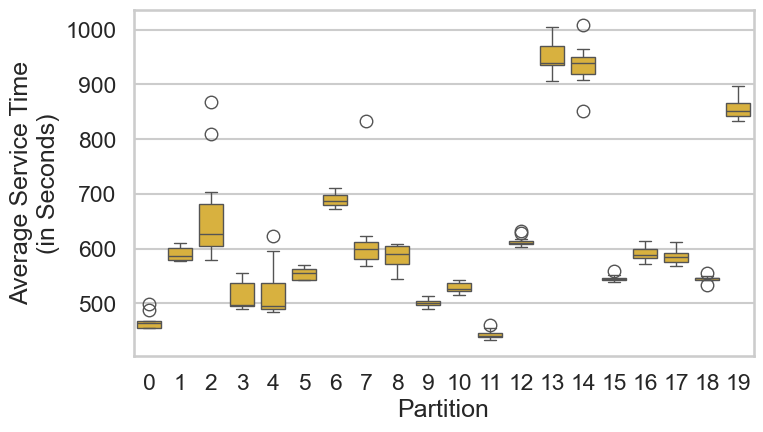

In [100]:
col_names = list(result_melt['Strategy'].sort_values().unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
col_names = [int(col_name) for col_name in col_names]
col_names.sort()

_, ax = plt.subplots(figsize=(8, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='Strategy', y='value', data=result_melt, color=pal[3])
ax.set_xticklabels(labels=col_names)
ax.set_xlabel("Partition")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.set_ylabel("Average Service Time\n(in Seconds)")
plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_per_partition.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

TypeError: object of type 'itertools.cycle' has no len()

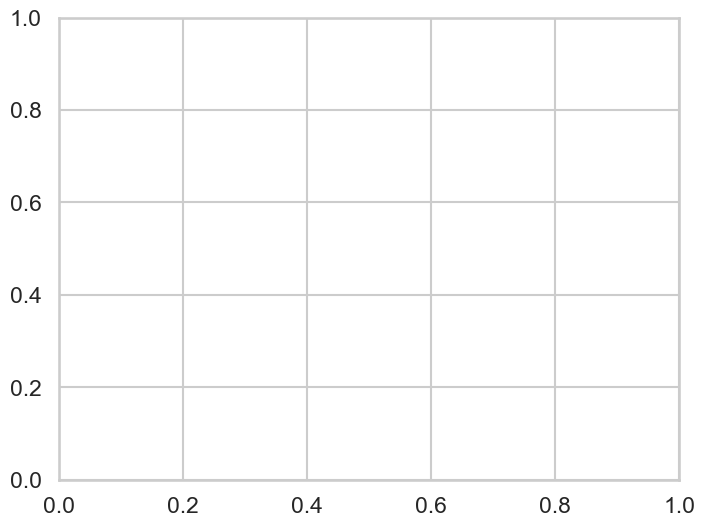

In [101]:
subset = [40, 50, 60, 70, 80,]
df_subset = result_melt[result_melt.Threshold.isin(subset)]
col_names = list(df_subset['Strategy'].sort_values().unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
col_names = [int(col_name) for col_name in col_names]
col_names.sort()

_, ax = plt.subplots(figsize=(8, 6))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.lineplot(x='Strategy', y='value', data=df_subset, hue="Threshold", palette=palette)
ax.set_xticklabels(labels=col_names)
ax.set_xlabel("Partition")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.set_ylabel("Average Service Time\n(in Seconds)")

plt.savefig(f'{root_dir}/lineplot__kpi__average_service_time_thresholds.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

In [102]:
result_melt.describe()

,Strategy,Threshold,value
count,220,220,220.0
unique,20,11,197.0
top,0,30,541.4
freq,11,20,2.0


In [103]:
df_subset[df_subset["Threshold"]=="DQN"]["value"].mean()

nan

In [104]:
df_subset[df_subset["Threshold"]=="random"]["value"].mean()

nan

C:\Users\zm0714\AppData\Local\Temp\ipykernel_17568\741231894.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Threshold', y='value', data=df_subset, palette=palette, showmeans=True, showfliers=True)
C:\Users\zm0714\AppData\Local\Temp\ipykernel_17568\741231894.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


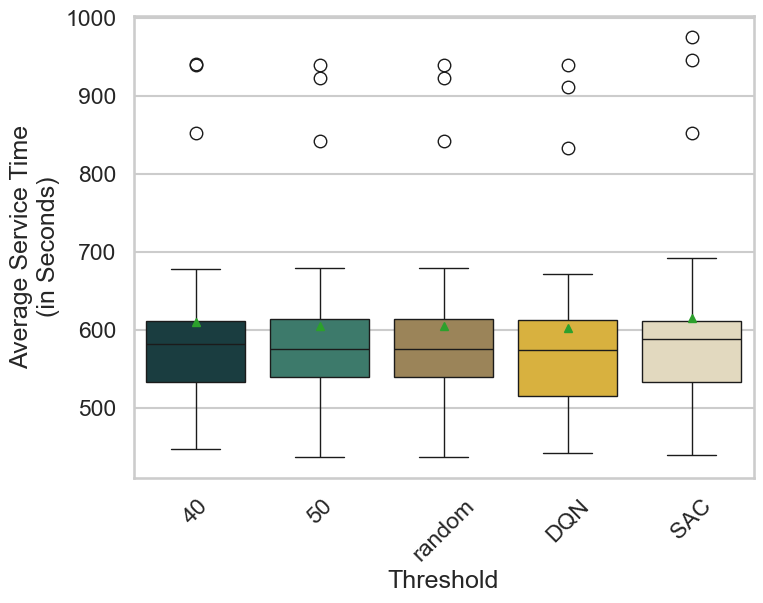

In [105]:
subset = [40, 50, "random", "DQN", "SAC"]
df_subset = result_melt[result_melt.Threshold.isin(subset)]
col_names = list(df_subset['Strategy'].sort_values().unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
col_names = [int(col_name) for col_name in col_names]
col_names.sort()

_, ax = plt.subplots(figsize=(8, 6))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='Threshold', y='value', data=df_subset, palette=palette, showmeans=True, showfliers=True)
# ax.set_xticklabels(labels=col_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel("Threshold")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.set_ylabel("Average Service Time\n(in Seconds)")

plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_partitions.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

In [64]:
sns.set_style('whitegrid')
sns.set_context('talk')

In [ ]:
def trim_duplicate_signal_values(ts_df, column, verbose=False, samples=10000):
    ts_to_trim = ts_df[[column]].round(decimals=2)
    if verbose:
        print(f'Number of values in {column} before '
              f'trimming: {ts_to_trim.size}')
    ts_to_trim_shift_r = ts_to_trim.shift(1)
    ts_to_trim_shift_l = ts_to_trim.shift(-1)
    ts_trimmed = ts_to_trim[
        (ts_to_trim[column] != ts_to_trim_shift_r[column]) |
        (ts_to_trim[column] != ts_to_trim_shift_l[column])]
    # display(df_stufe_min_data)
    if verbose:
        print(f'Number of values in {column} after '
              f'trimming: {ts_trimmed.size}')
        print(f'Number of values after uniform sampling: {samples}')
    adjusted_n_samples = min(samples, ts_trimmed.shape[0])
    return ts_trimmed[column].sample(adjusted_n_samples)

def get_x_values(ts_df, index, column):
    return ts_df[column].loc[list(index)]

In [ ]:
%%time

def plot_indicator(df, column_name, x_axis_col='kpi__makespan', ax=None, 
                   n_samples=10000, color=None, label='', alpha=1):
    trimmed_signal = trim_duplicate_signal_values(
        df, column_name, False, n_samples)
    time = get_x_values(df, trimmed_signal.index, x_axis_col)
    ax_modified = sns.lineplot(
        x=time, y=trimmed_signal.values, ax=ax, color=color, label=label, 
        alpha=alpha)
    ax_modified.set_ylabel(
        ' '.join([s.capitalize() for s in column_name.split('_')]))
    ax_modified.set_xlabel('Time (in Seconds)')
    return ax_modified

plot_indicator(dfs_d[10][0], 'fill_level')

In [ ]:
plot_indicator(dfs_d[10][0], 'kpi__average_service_time')

In [ ]:
plot_indicator(dfs_d[10][3], 'kpi__average_service_time')

In [ ]:
plot_indicator(dfs_d[10][0], 'n_pallet_shifts')

In [ ]:
plot_indicator(dfs_d[10][0], 'n_queued_delivery_orders')

In [ ]:
plot_indicator(dfs_d[10][0], 'n_queued_retrieval_orders')

In [ ]:
plot_indicator(dfs_d[10][0], 'n_queued_charging_events')

In [ ]:
dfs_d[10][0].columns

In [ ]:
%%time


def get_indicator_columns(df_cols):
    # res_cols_base = [
    #     'total_distance', 
    #     'average_distance',
    #     'travel_time_retrieval_ave',
    #     'distance_retrieval_ave', 
    #      'utilization_time',
    #     'n_queued_retrieval_orders', 
    #      'n_queued_delivery_orders', #'n_finished_orders', 
    #     'kpi__throughput', #'kpi__makespan',
    #      'entropy',
    #      'kpi__average_service_time', #'runtime', 
    #     'kpi__cycle_time',
    #     'n_free_agvs',
    #     'n_pallet_shifts', #'n_steps', 'n_decision_steps', 
    #     'fill_level'
    # ]
    res_cols_base = [
        'n_queued_retrieval_orders',  #'n_finished_orders', 
        'kpi__throughput',
         'kpi__average_service_time', 
        'n_agv_depleted', #'n_steps', 'n_decision_steps', 
        'fill_level',
        'n_queued_charging_events',
        'n_pallet_shifts'
    ]
    zone_fill_cols = []
    for i in range(5):
        col_candidate = f'fill_zone_{i}'
        if  col_candidate in list(df_cols): 
            zone_fill_cols.append(col_candidate)
    return res_cols_base + zone_fill_cols

def make_space_above(axes, topmargin=1):
    """ increase figure size to make topmargin (in inches) space for 
        titles, without changing the axes sizes"""
    fig = axes.flatten()[0].figure
    s = fig.subplotpars
    w, h = fig.get_size_inches()

    figh = h - (1-s.top)*h  + topmargin
    fig.subplots_adjust(bottom=s.bottom*h/figh, top=1-topmargin/figh)
    fig.set_figheight(figh)
    
def plot_all_experiments(dfs):
    for df_all in dfs:
        print(f"Experiment Results for {df_all.name}")
        palette = cycle(sns.color_palette('cubehelix', 25))

        cols_to_plot = get_indicator_columns(df_all.columns)
        nrows = len(cols_to_plot) // 2 + len(cols_to_plot) % 2
        _, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(16, 35))
        i = 0
        for col_name in cols_to_plot:
            ax = plot_indicator(df_all, col_name, 'kpi__makespan', 
                                ax=axes[i // 2][i % 2], color=next(palette))
            if i // 2 != nrows - 1:
                ax.set_xlabel('')
            i += 1
        plt.tight_layout()
        plt.suptitle(f'{df_all.name}', y=0.99, fontsize=20, fontweight='bold')
        make_space_above(axes, topmargin=1)
        #plt.savefig(f'{root_dir}/{df_all.name}.png', dpi=200, bbox_inches='tight', pad_inches=0)
        plt.show()
        

#plot_all_experiments(best_dfs)

In [ ]:
len(dfs_d[0])

In [ ]:
for df in best_dfs:
    print(df.name)

In [ ]:
times = []
best_tmp = []
for df in best_dfs:
    if df.name == 'SL':
        continue
    else:
        if df.name == 'SLO':
            df.name = 'SL'
        best_tmp.append(df)
    times.append(df['kpi__makespan'].max())
    print(df.name, df['kpi__makespan'].max())
print(min(times))
best_dfs = best_tmp

In [ ]:
%%time

from shlex import quote as q

from ast import literal_eval as le

def plot_best_results(dfs):
    nrows = []
    for df_all in dfs:
        cols_to_plot = get_indicator_columns(df_all.columns)
        print(cols_to_plot)
        nrows.append(len(cols_to_plot) // 2 + len(cols_to_plot) % 2)
    
    mnrows = max(nrows)
    _, axes = plt.subplots(nrows=mnrows, ncols=2, figsize=(16, 5 * mnrows))
    palette = cycle(sns.color_palette('cubehelix', 4))
    
    alpha = 1
    for df_all in reversed(dfs):
        print(f'Adding behavioral curves for {df_all.name}...')
        i = 0
        alpha -= 0.7 / len(dfs)
        color = next(palette)
        cols_to_plot = get_indicator_columns(df_all.columns)
        for col_name in cols_to_plot:
            ax = plot_indicator(df_all, col_name, 'kpi__makespan', 
                                ax=axes[i // 2][i % 2], color=color, 
                                label=df_all.name, alpha=1)
            if i // 2 != mnrows - 1:
                ax.set_xlabel('')
            if col_name.startswith('kpi'):
                ax.set_ylabel(ax.get_ylabel()[4:])
            elif col_name.startswith('n'):
                ax.set_ylabel(ax.get_ylabel()[2:])
            i += 1
    plt.tight_layout()
    plt.suptitle(f'Experiment Comparison', y=0.99, 
                 fontsize=20, fontweight='bold')
    make_space_above(axes, topmargin=1)
    plt.savefig(f'{root_dir}/best_strategy_comparison_more_indicators.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()


def add_newline(s):
    segs = s.split(r'\n')
    return '\n'.join(segs)
    
def plot_best_results_individually(dfs, column_subset=None, plot_start_nr=0, constraints=None, pal=None):
    if column_subset is not None:
        cols_to_plot = column_subset
    else:
        cols_to_plot = get_indicator_columns(dfs[0].columns)
    i = plot_start_nr
    for col_name in cols_to_plot:
        col_plot_name = ''.join([s.capitalize() for s in col_name.split('_')])
        print(f'Adding behavioral curves for {col_plot_name}...')
        alpha = 1
        _ = plt.figure(figsize=(8, 4.5))
        n_colors = len(dfs)
        if pal is not None:
            palette = cycle(pal)
        else:
            palette = cycle(sns.color_palette('cubehelix', n_colors))
        if col_name == 'n_free_agvs':
            for df_all in reversed(dfs):
                color = next(palette)
                trimmed_signal = trim_duplicate_signal_values(
                    df_all, col_name, False, 10000)
                time = get_x_values(df_all, trimmed_signal.index, 'kpi__makespan')
                ax = sns.lineplot(
                    x=time, y=1-trimmed_signal.values/n_agvs, color=color, label=df_all.name, 
                    alpha=alpha)
                ax.set_xlabel('Time (in Seconds)')
        else:
            for df_all in reversed(dfs):
                color = next(palette)
                ax = plot_indicator(df_all, col_name, 'kpi__makespan', 
                                    color=color, label=df_all.name, alpha=alpha)
        if constraints is not None and col_name in constraints:
            ax.axhline(constraints[col_name], 
                       color='red', linestyle='dashdot', label='Buffer Limit') 
            plt.legend()
#             labels = ["some name", "some other name", "horizontal"]
#             handles, _ = ax.get_legend_handles_labels()

#             # Slice list to remove first handle
#             plt.legend(handles = handles[1:], labels = labels)
        
        # y_label = add_newline(input(f"Y-Axis name for the {col_name} indicator:"))
        y_label = add_newline(col_name)
        print(y_label)
        # draw_x_label = input("Plot for figure bottom?:")
        draw_x_label = 'y'
        ax.set_ylabel(y_label)
        ax.legend(title="SLAP Strategy")
        if not draw_x_label == 'y':
            ax.set_xlabel('')
        plt.tight_layout()
        # plt.savefig(f'{root_dir}/res_{i}_{col_name}.png', 
        #             dpi=200, bbox_inches='tight', pad_inches=0)
        plt.show()
        i += 1
        plt.show()
    
    
col_subset = [
    'total_distance',
    'n_queued_delivery_orders',
    'n_queued_retrieval_orders',
    'fill_level', 
    'entropy',
    'kpi__average_service_time', 
    'utilization_time', 
    'n_free_agvs',
    'n_queued_charging_events',
    'avg_battery_level',
    'n_agv_depleted'
]

constraints = {
    'n_queued_delivery_orders': 300,
    'n_queued_retrieval_orders': 300,
    'kpi__average_service_time': 600
}

plot_best_results(best_dfs)
#plot_best_results_individually(dfs_d[4], col_subset, 1, pal=pal)#, constraints)

In [ ]:
best_dfs[0]

In [ ]:
##################################################################################
pal = sns.color_palette(['#144246', '#a6874e', '#FFFF33', '#FFD801', '#FFDF00', 
                         '#f2be25', '#e8dcb9', '#338470', '#69657e'], desat=1)

##################################################################################
umsatz_gabelstapler = pd.DataFrame(
    [(56.6, "Global", "2021"), (103.9, "Global", "2031"), 
     (16.63, "EU", "2021"), (44.24, "EU", "2031")], columns=['Umsatz (Mrd \$)', 'Region', 'Year'])
umsatz_gabelstapler_g = pd.DataFrame(
    [(237, "Global", "2020"), (294, "Global", "2021"), 
     (77, "EU", "2020"), (98, "EU", "2021")], columns=['Umsatz (Tausend \$)', 'Region', 'Year'])
umsatz_gabelstapler_a = pd.DataFrame(
    [(0.371, "2019", "Projektion"), 
     (5.69, "2027", "Projektion"), (13.4, "2030", "Projektion")], 
    columns=['Umsatz (Mrd \$)', 'Year', "Proj"])


##################################################################################
_, axes = plt.subplots(1, 2, figsize=(7.5, 4), gridspec_kw={'width_ratios':[4, 3]})

ax = sns.barplot(
    data=umsatz_gabelstapler, 
    x='Year', y='Umsatz (Mrd \$)', hue='Region', 
    ax=axes[0], palette=[pal[1], pal[5]], saturation=1
)
ax.set_title("Projected Forklift Sales")
ax.legend(loc='upper left')
ax.set_ylabel("Billion \$")

# ax = sns.barplot(
#     data=umsatz_gabelstapler_g, 
#     x='Year', y='Umsatz (Tausend \$)', hue='Region', 
#     ax=axes[1], palette=[pal[-2], pal[-1]]#, saturation=1
# )
# ax.set_title("Gegengewichtgabelstaplerumsatz")
# ax.legend(loc='upper right')

ax = sns.barplot(
    data=umsatz_gabelstapler_a, 
    x='Year', y='Umsatz (Mrd \$)', color=pal[0],
    ax=axes[1], saturation=1
)
ax = sns.lineplot(data=umsatz_gabelstapler_a, x=umsatz_gabelstapler_a['Year'], 
                  y=umsatz_gabelstapler_a['Umsatz (Mrd \$)'], 
                  color=pal[-2], ax=ax, markers=["o"], style="Proj", legend=False)
ax.set_title("Projected Counterbalance\nForklift Sales")
ax.set_ylabel(None)

plt.tight_layout()
plt.savefig("9_umsatz_gabelstapler_v3.png", dpi=200, bbox_inches='tight', pad_inches=0.02)
plt.show()

### 4. Experiment Script <a id=experiments>
    
[Back to Overview](#ov)

In [ ]:
from typing import List

import pandas as pd

import numpy as np
from tqdm import tqdm
import time

from slapstack_controls.output_converters import FeatureConverter
from slapstack.core_state import State, StateCache
from slapstack.interface import SlapEnv
from slapstack.helpers import create_folders, TravelEventKeys, \
    parallelize_heterogeneously
from slapstack.interface_templates import SimulationParameters, SlapLogger
from slapstack_controls.storage_policies import (ClassBasedPopularity,
                                       ClassBasedCycleTime,
                                       ClosestOpenLocation,
                                       BatchLIFO, StoragePolicy)


class ExperimentLogger(SlapLogger):
    def __init__(self, filepath: str, logfile_name: str = 'experiment_data',
                 n_steps_between_saves=10000, nr_zones=3):
        super().__init__(filepath)
        self.n_steps_between_saves = n_steps_between_saves
        self.log_dir = filepath
        create_folders(f'{self.log_dir}/dummy')
        self.logfile_name = logfile_name
        self.log_data = []
        self.prev_n_orders = 0
        self.n_zones = nr_zones

    def set_logfile_name(self, logfile: str):
        self.logfile_name = logfile

    def log_state(self, s: State):
        first_step = len(self.log_data) == 0
        save_logs = len(self.log_data) % self.n_steps_between_saves == 0
        n_orders = len(s.trackers.finished_orders)
        if n_orders != self.prev_n_orders:
            self.prev_n_orders = n_orders
            self.log_data.append(ExperimentLogger.__get_row(s))
            if (not first_step and save_logs) or s.done:
                cols = self.__get_header()
                df = pd.DataFrame(data=self.log_data,
                                  columns=cols)
                df.to_csv(f'{self.log_dir}/{self.logfile_name}_{n_orders}.csv')
                self.log_data = []

    def __get_header(self):
        return [
            # Travel Info
            'total_distance',
            'average_distance',
            'travel_time_retrieval_ave',
            'distance_retrieval_ave',
            'utilization_time',
            # Order Info
            'n_queued_retrieval_orders',
            'n_queued_delivery_orders',
            'n_finished_orders',
            # KPIs
            'kpi__throughput',
            'kpi__makespan',
            'kpi__average_service_time',
            'kpi__cycle_time',
            # Broad Trackers
            'runtime',
            'n_free_agvs',
            'n_pallet_shifts',
            'n_steps',
            'n_decision_steps',
            'fill_level',
            'entropy'
        ] + [f'fill_zone_{i}' for i in range(self.n_zones)]

    @staticmethod
    def __get_row(s: State):
        zm = s.state_cache.zone_manager
        tes = s.trackers.travel_event_statistics
        t = s.trackers
        sc = s.state_cache
        am = s.agv_manager
        n_orders = len(t.finished_orders)
        row = (
            # Travel Info:
            tes.total_distance_traveled,
            tes.average_travel_distance(),
            tes.get_average_travel_time_retrieval(),
            tes.get_average_travel_distance_retrieval(),
            am.get_average_utilization() / s.time if s.time != 0 else 0,
            # Order Info:
            t.n_queued_retrieval_orders,
            t.n_queued_delivery_orders,
            len(t.finished_orders),
            # KPIs
            ExperimentLogger.__get_throughput(s),  # throughput
            s.time,  # makespan
            t.average_service_time,
            ExperimentLogger.__get_cycle_time(sc),
            # Broad Trackers
            time.time(),
            am.n_free_agvs,
            t.number_of_pallet_shifts,
            s.n_steps + s.n_silent_steps,
            s.n_steps,
            t.get_fill_level(),
            ExperimentLogger.__get_lane_entropy(sc)
        )
        fill_level_per_zone = tuple(
                1 - np.array(list(zm.n_open_locations_per_zone.values())) /
                np.array(list(zm.n_total_locations_per_zone.values()))
        )
        return row + fill_level_per_zone

    @staticmethod
    def __get_cycle_time(sc: StateCache):
        sku_cycle_times = sc.sku_cycle_time
        sum_cycle_times = 0
        if len(sku_cycle_times) != 0:
            for sku, cycle_time in sku_cycle_times.items():
                sum_cycle_times += cycle_time
            return sum_cycle_times / len(sku_cycle_times)
        else:
            return 0

    @staticmethod
    def __get_lane_entropy(sc: StateCache):
        lane_entropies = sc.lane_wise_entropies
        average_entropy = 0
        for lane, entropy in lane_entropies.items():
            average_entropy += entropy
        return average_entropy / len(lane_entropies)

    @staticmethod
    def __get_throughput(s: State):
        t = s.trackers
        return len(t.finished_orders) / s.time if s.time != 0 else 0

    @staticmethod
    def print_episode_info(strategy_name: str, episode_start_time: float,
                           episode_decisions: int, end_state: State,
                           ep_nr: int):
        zm = end_state.state_cache.zone_manager
        tes = end_state.trackers.travel_event_statistics
        t = end_state.trackers
        fill_level_per_zone = \
            1 - np.array(list(zm.n_open_locations_per_zone.values())) / \
            np.array(list(zm.n_total_locations_per_zone.values()))

        sc = end_state.state_cache
        print(f"Episode {ep_nr + 1} with storage strategy "
              f"{strategy_name} ended after "
              f"{time.time() - episode_start_time} seconds:")
        print(f"\tBroad Trackers:")
        print(f"\t\tNumber of decisions: {episode_decisions}")
        print(f"\t\tNumber of pallet shifts: {t.number_of_pallet_shifts}")
        print(f"\t\tFill Level: {t.get_fill_level()}")
        print(f"\t\tFill level per zone: {fill_level_per_zone}")
        print(f'\t\tAverage Lane Entropy: '
              f'{ExperimentLogger.__get_lane_entropy(sc)}')
        print(f'\tKPI:')
        print(f'\t\tThroughput: {ExperimentLogger.__get_throughput(end_state)}')
        print(f"\t\tMakespan: {end_state.time}")
        print(f"\t\tMean service time: {t.average_service_time}")
        print(f'\t\tCycle Time: {ExperimentLogger.__get_cycle_time(sc)}')
        print("\tTravel Info:")
        print(f"\t\tTotal travel distance: {tes.total_distance_traveled}")
        print(f"\t\tMean travel distance: {tes.average_travel_distance()}")
        print(f"\t\tMean travel time: {tes.average_travel_time()}")
        mean_dist_ret = (
                (tes.average_travel_distance(TravelEventKeys.RETRIEVAL_2ND_LEG)
                 + tes.average_travel_distance(TravelEventKeys.RETRIEVAL_1STLEG))
                / 2)
        print(f"\t\tMean travel distance retrieval: {mean_dist_ret}")
        mean_time_ret = (
            (tes.average_travel_time(TravelEventKeys.RETRIEVAL_2ND_LEG)
             + tes.average_travel_time(TravelEventKeys.RETRIEVAL_1STLEG)) / 2)
        print(f"\t\tMean travel time retrieval: "
              f"{mean_time_ret}")
        print(f'\t\tAverage AGV utilization: '
              f'{end_state.agv_manager.get_average_utilization() / end_state.time}')
        print(f"\tOrder Info:")
        print(f"\t\tPending Retrieval Orders: {t.n_queued_retrieval_orders}")
        print(f"\t\tPending Delivery Orders: {t.n_queued_delivery_orders}")
        print(f"\t\tNumber of orders completed: {len(t.finished_orders)}")
        print(f"\t\tNumber of Visible AGVs: {end_state.agv_manager.n_visible_agvs}")


def get_episode_env(n_partitions: int, use_case_partition_nr: int,
                    log_frequency: int, nr_zones: int):
    params = SimulationParameters(
        use_case_root_dir="use_case",
        use_case_n_partitions=n_partitions,
        use_case_partition_to_use=use_case_partition_nr,
        n_agvs=40,
        generate_orders=False,
        verbose=False,
        resetting=False,
        initial_pallets_storage_strategy=ClassBasedPopularity(
            retrieval_orders_only=False,
            future_counts=True,
            init=True,
            n_zones=nr_zones
        ),
        pure_lanes=True,
        # https://logisticsinside.eu/speed-of-warehouse-trucks/
        agv_speed=2,
        unit_distance=1.4,
        pallet_shift_penalty_factor=20,  # in seconds
        compute_feature_trackers=True
    )
    seeds = [56513]
    return SlapEnv(
        params, seeds,
        logger=ExperimentLogger(
            './result_data/', n_steps_between_saves=log_frequency,
            nr_zones=nr_zones),
        action_converters=[BatchLIFO()])


def run_episode(storage_strategy: StoragePolicy,
                ep_nr: int, n_progress_bar_orders=0, print_freq=0):
    # env_cp, done, n_decisions = deepcopy(environment), False, 0
    if n_progress_bar_orders:
        pbar = tqdm(total=n_progress_bar_orders)
    if hasattr(storage_strategy, 'n_zones'):
        environment: SlapEnv = get_episode_env(
            1, ep_nr, log_frequency=1000,
            nr_zones=storage_strategy.n_zones)
    else:
        environment: SlapEnv = get_episode_env(
            1, ep_nr, log_frequency=1000, nr_zones=3)
    done, n_decisions = False, 0
    state = environment.core_env.state
    # state.zone_manager.perform_sanity_check()
    environment.core_env.logger.set_logfile_name(
        f'ep{ep_nr}_{storage_strategy.name}')
    start = time.time()
    while not done:
        step_ts = time.time()
        # if state.decision_mode == "delivery":
        #     assert len(state.state_cache.legal_actions) <= len(
        #         state.state_cache.open_storage_locations)
        if len(state.trackers.finished_orders) < 1000:
            # warm start ;)
            action = ClosestOpenLocation().get_action(state)
        else:
            action = storage_strategy.get_action(state)
        as_time = time.time()
        state: State
        output, reward, done, info = environment.step(action)
        step_time = time.time()
        if print_freq and n_decisions % print_freq == 0:
            ExperimentLogger.print_episode_info(
                storage_strategy.name, start, n_decisions,
                environment.core_env.state, ep_nr)
            # state.zone_manager.perform_sanity_check()
        n_decisions += 1
        if n_progress_bar_orders:
            # noinspection PyUnboundLocalVariable
            pbar.update(1)
        # if n_decisions > 10000:
        #     break
    ExperimentLogger.print_episode_info(
        storage_strategy.name, start, n_decisions,
        environment.core_env.state, ep_nr)


def get_storage_strategies(nr_zones: List[int]):
    storage_strategies = []
    for n_zone in nr_zones:
        storage_strategies += [
            ClassBasedCycleTime(
                n_orders=10000, recalculation_steps=1000, n_zones=n_zone),
            ClassBasedPopularity(
                retrieval_orders_only=False, n_zones=n_zone,
                future_counts=True,
                name=f'allOrdersPopularity_future_z{n_zone}'),
            ClassBasedPopularity(
                retrieval_orders_only=True, n_zones=n_zone,
                future_counts=True,
                name=f'retrievalPopularity_future_z{n_zone}'),
            ClassBasedPopularity(
                retrieval_orders_only=False, n_zones=n_zone,
                future_counts=False, n_orders=10000, recalculation_steps=1000,
                name=f'allOrdersPopularity_past_z{n_zone}'),
            ClassBasedPopularity(
                retrieval_orders_only=True, n_zones=n_zone,
                future_counts=False, n_orders=10000, recalculation_steps=1000,
                name=f'retrievalPopularity_past_z{n_zone}')
        ]
    storage_strategies += [
        ClosestOpenLocation(very_greedy=True),
        ClosestOpenLocation(very_greedy=False),
    ]
    return storage_strategies


# TODO. think about and (re)program visualization
storage_policies = get_storage_strategies([2])
partitions = 1

# if __name__ == '__main__':
#     for j in range(0, partitions):
#         n_strategies = len(storage_policies)
#         for i in range(0,n_strategies):
#             run_episode(storage_policies[i], j, 205000, 1000)

#         # parallelize_heterogeneously(
#         #     [run_episode] * n_strategies,
#         #     list(zip(storage_policies,
#         #              [j] * n_strategies)))